In [51]:
import pandas as pd
import numpy as np
import csv
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler

# from sklearn.impute import IterativeImputer

In [52]:
data_dir = "../data/"
data_info = "../data/dataset_info.json"
normalized_data_dir = "../cleaned_data/"
station_info = "../JSON/station_info.json"


In [53]:
province_dict = {
  "mien_bac": [
    "ha_giang",
    "cao_bang",
    "bac_kan",
    "lang_son",
    "quang_ninh",
    "thai_nguyen",
    "phu_tho",
    "bac_giang",
    "tuyen_quang",
    "dien_bien",
    "lao_cai",
    "yen_bai",
    "son_la",
    "hoa_binh",
    "thai_binh",
    "hai_phong",
    "hai_duong",
    "hung_yen",
    "vinh_phuc",
    "ha_nam",
    "nam_dinh",
    "ninh_binh",
    "ha_noi"
  ],
  "mien_trung": [
    "thanh_hoa",
    "nghe_an",
    "ha_tinh",
    "quang_binh",
    "quang_tri",
    "thua_thien_hue",
    "da_nang",
    "quang_nam",
    "quang_ngai",
    "binh_dinh",
    "phu_yen",
    "khanh_hoa",
    "ninh_thuan",
    "binh_thuan",
    "kon_tum",
    "gialai",
    "dak_lak",
    "dak_nong",
    "lam_dong"
  ],
  "mien_nam": [
    "binh_phuoc",
    "tay_ninh",
    "binh_duong",
    "dong_nai",
    "ba_ria_vung_tau",
    "ho_chi_minh",
    "long_an",
    "tien_giang",
    "ben_tre",
    "vinh_long",
    "dong_thap",
    "an_giang",
    "kien_giang",
    "can_tho",
    "hau_giang",
    "soc_trang",
    "bac_lieu",
    "ca_mau",
    "tra_vinh"
  ]
}

In [54]:
def drop_col():
    with open(data_info, "r", encoding='utf-8') as json_info:
        info = json.load(json_info)
    info
    for i in range(len(info)):
        csv_path = info[str(i)]["file_name"]
        df = pd.read_csv(data_dir+csv_path, delimiter=',')
        df = df.T.drop_duplicates().T
        df = df.drop(columns=["STT"], axis=1)

        for attr in df.columns.to_list():
            arr: np
            arr = df[attr].to_numpy()
            miss_rate = np.where(arr == '-')[0].shape[0]/df.shape[0]
            
            if miss_rate > 0.75:
                print(f"Remove column [{attr}] with [{miss_rate*100:.5}%] missing rate")
                df = df.drop(columns=[attr], axis=1)

        df.to_csv(normalized_data_dir+csv_path, sep=',', index=False, encoding='utf-8')
        df.head(5)
# drop_col()

In [55]:
def split_data(csv_obj, n_records, ratio=0.1):

    # first_ratio_row = csv_obj.head(int(ratio * jobj[str(i)]["n_records"]))
    # print(first_ratio_row)
    test_part = csv_obj.iloc[:int(ratio*n_records)]
    train_part = csv_obj.iloc[int(ratio*n_records):]

    return train_part, test_part

def update_n_records(dir):
    with open(dir+'dataset_info.json', 'r', encoding='utf-8') as f:
        jobj = json.load(f)

    for i in range(len(jobj)):
        file_name = jobj[str(i)]["file_name"]
        csv_obj = pd.read_csv(dir+file_name, delimiter=',', encoding='utf-8')

        new_n_records = csv_obj.shape[0]
        jobj[str(i)]["n_records"] = new_n_records 

    with open(dir+'dataset_info.json', 'w', encoding='utf-8') as f:
        json.dump(jobj, f, indent=4)

    return 

In [56]:
def fill_missing(csv_obj: pd.DataFrame):
    '''
        We have two option, using linear univariate interpolation or multivariate imputation if we want advanced.
    '''
    cols = ['VN_AQI', 'CO', 'PM-10', 'PM-2-5', 'SO2', \
            'mon', 'tu', 'wed', 'thu', 'fri', 'sat', 'sun', \
            'north', 'middle', 'south', \
            'spring', 'summer', 'autumn', 'winter', 'dry', 'rain'
            ]
    csv_obj[cols] = csv_obj[cols].apply(pd.to_numeric).astype(np.float64)

    csv_obj['CO'] = csv_obj['CO'].interpolate(method='linear', limit_direction='both')
    csv_obj['PM-10'] = csv_obj['PM-10'].interpolate(method='linear', limit_direction='both')
    csv_obj['PM-2-5'] = csv_obj['PM-2-5'].interpolate(method='linear', limit_direction='both')
    csv_obj['SO2'] = csv_obj['SO2'].interpolate(method='linear', limit_direction='both')
    return csv_obj

# fill_missing("../chosen_data/")

In [57]:
def plot_histogram(csv_obj, station_name):

    # Tạo figure với 5 subplot nằm ngang
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fields = ['VN_AQI', 'CO', 'PM-10', 'PM-2-5', 'SO2']

    # Vẽ biểu đồ phân phối cho từng trường
    for i, field in enumerate(fields):
        sns.histplot(data=csv_obj, x=field, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Phân phối {field}')
        axes[i].set_xlabel(field)
        axes[i].set_ylabel('Tần suất')
    plt.title(f"Station: {station_name}")
    plt.tight_layout()
    plt.show()
    prefix = station_name.split('.')[0]

    plt.savefig('../chosen_data/train_pdf/histogram/'+prefix+'_Histogram', format='pdf')

    return 

In [58]:
def plot_time_series(df, time_column, file_name):
    fields = ['VN_AQI', 'CO', 'PM-10', 'PM-2-5', 'SO2']

    # Tạo figure lớn với 5 subplot dọc
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)

    # Vẽ từng biểu đồ đường
    for i, field in enumerate(fields):
        axes[i].plot(df[time_column], df[field], label=field, color='tab:blue')
        axes[i].set_title(f'Biểu đồ {field} theo thời gian')
        axes[i].set_ylabel(field)
        axes[i].legend()
        axes[i].grid(True)

    # Gán nhãn trục x cho subplot cuối cùng
    axes[-1].set_xlabel('Thời gian')

    # Tối ưu bố cục
    plt.tight_layout()
    plt.show()

    prefix = file_name.split('.')[0]

    plt.savefig('../chosen_data/train_pdf/time_series/'+prefix+'_TimeSeries', format='pdf')

# Gọi hàm
# plot_time_series(df, 'ThoiGian', ['VN_AQI', 'CO', 'PM-10', 'PM-2-5', 'SO2'])


In [59]:
def normalize(csv_obj: pd.DataFrame, csv_obj_test: pd.DataFrame, file_name):

    # First, apply log transform to push the origin distribution closer to the Gaussian Standard Distribution.
    # Them apply Gaussian Standard scaling
    numeric_cols = ['VN_AQI', 'CO', 'PM-10', 'PM-2-5', 'SO2']
    log_cols = [f'{col}_log' for col in numeric_cols]

    for col in numeric_cols:
        csv_obj[f"{col}_log"] = np.log1p(csv_obj[col]) # ln(1+x)
        csv_obj_test[f"{col}_log"] = np.log1p(csv_obj_test[col])

    scaler = StandardScaler()
    csv_obj[log_cols] = scaler.fit_transform(csv_obj[log_cols])
    csv_obj_test[log_cols] = scaler.transform(csv_obj_test[log_cols])
    print(csv_obj.head(5))
    print(csv_obj_test.head(5))
    # means = scaler.mean_
    # stds = scaler.scale_

    # mean_std_dict = {
    #     "file_name": f"{file_name}",
    #     "VN_AQI": {
    #         "mean": f"{means[0]}",
    #         "std": f"{stds[0]}",
    #     },
    #     "CO": {
    #         "mean": f"{means[1]}",
    #         "std": f"{stds[1]}",
    #     },
    #     "PM-10": {
    #         "mean": f"{means[2]}",
    #         "std": f"{stds[2]}",
    #     },
    #     "PM-2-5": {
    #         "mean": f"{means[3]}",
    #         "std": f"{stds[3]}",
    #     },
    #     "SO2": {
    #         "mean": f"{means[4]}",
    #         "std": f"{stds[4]}",
    #     }
    # }

    scaler_dict = {
        "file_name": f"{file_name}",
        "scaler": scaler
    }
    
    # normalized to the test file right nowwwww
    
    return csv_obj, csv_obj_test, scaler_dict

Date           0.0
Day_Of_Week    0.0
VN_AQI         0.0
CO             0.0
PM-10          0.0
PM-2-5         0.0
SO2            0.0
mon            0.0
tu             0.0
wed            0.0
thu            0.0
fri            0.0
sat            0.0
sun            0.0
north          0.0
middle         0.0
south          0.0
spring         0.0
summer         0.0
autumn         0.0
winter         0.0
dry            0.0
rain           0.0
dtype: float64


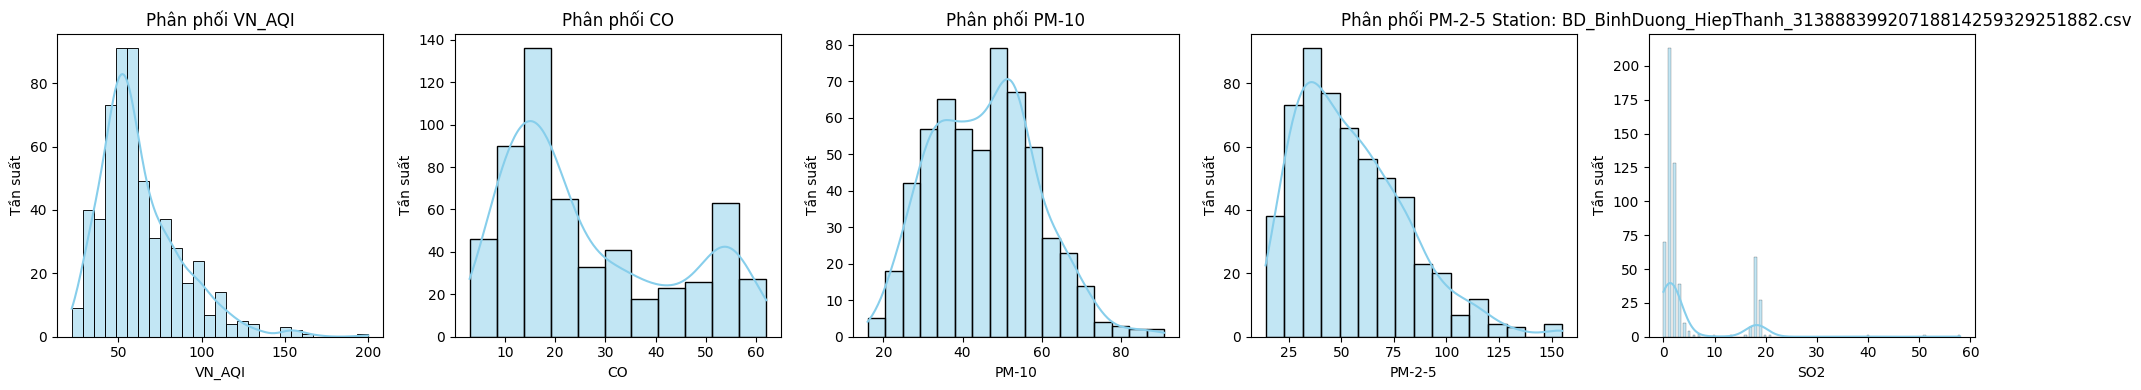

<Figure size 640x480 with 0 Axes>

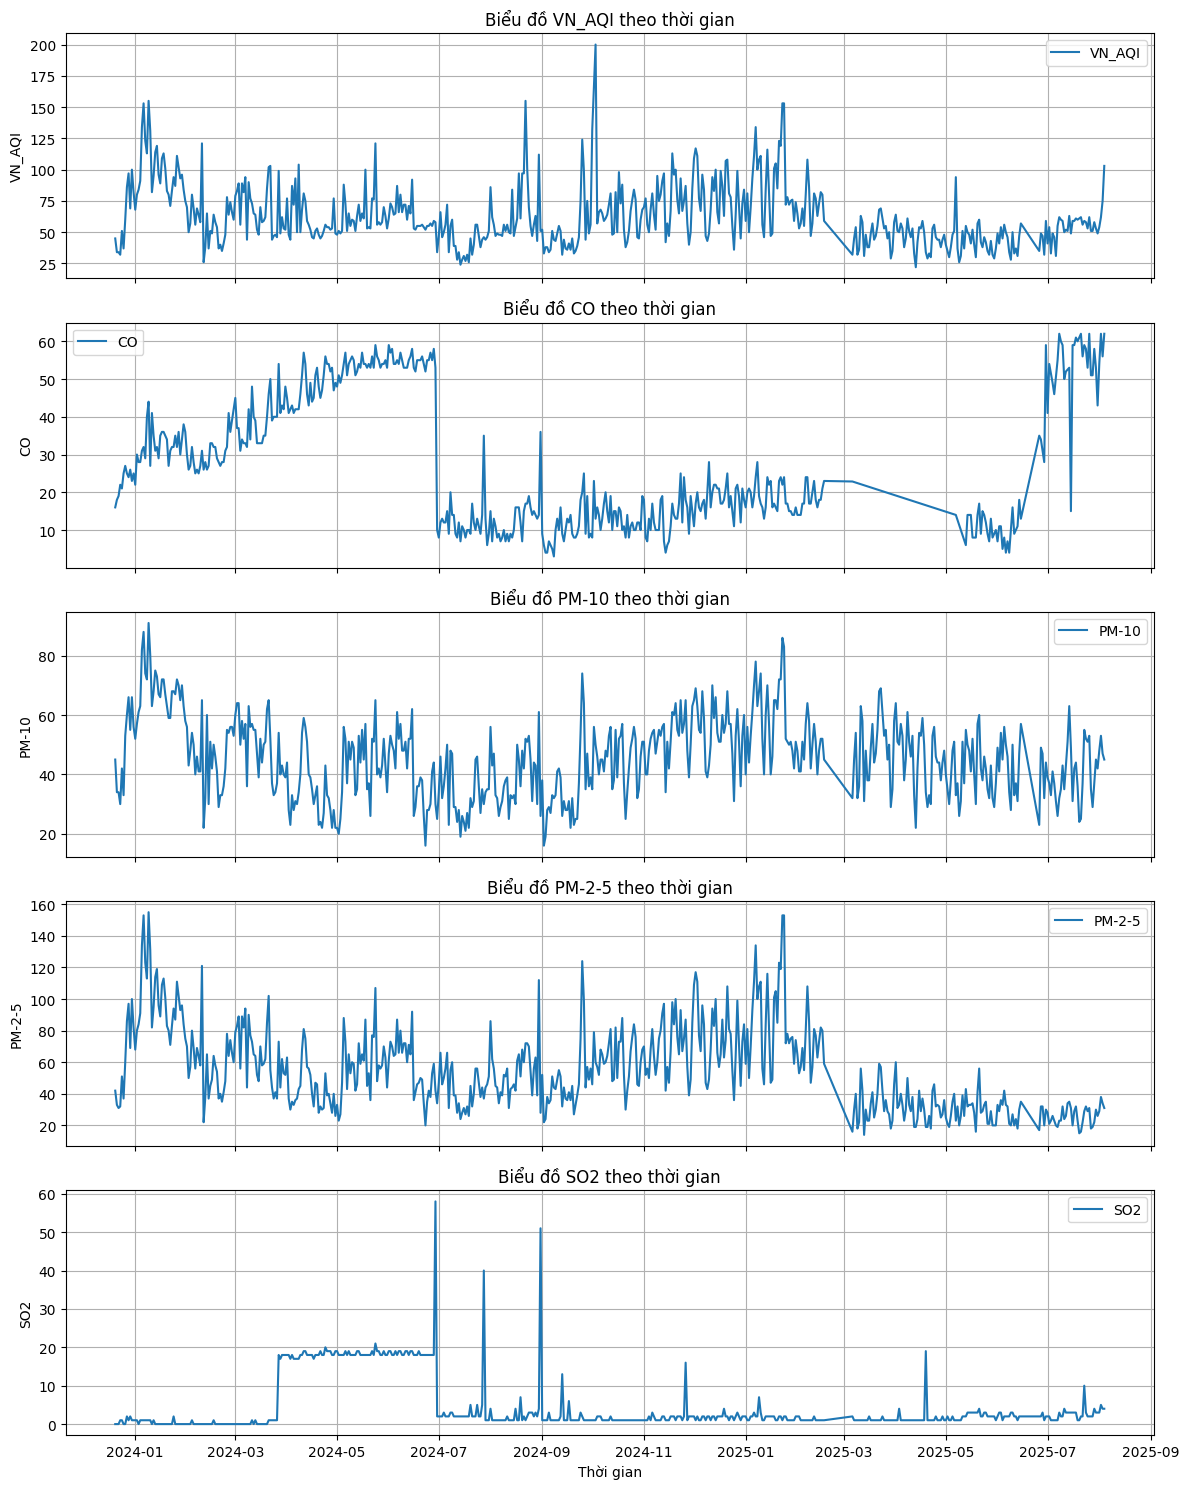

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
63            0   103.0  62.0   45.0    31.0  4.0  1.0  0.0  0.0  0.0  ...   
64            6    75.0  56.0   47.0    34.0  4.0  0.0  0.0  0.0  0.0  ...   
65            5    62.0  62.0   53.0    38.0  5.0  0.0  0.0  0.0  0.0  ...   
66            4    54.0  54.0   48.0    29.0  3.0  0.0  0.0  0.0  0.0  ...   
67            3    49.0  43.0   42.0    26.0  3.0  0.0  0.0  0.0  1.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
63     0.0     0.0     0.0  1.0   0.0    1.552532  1.621866   0.095879   
64     0.0     0.0     0.0  1.0   0.0    0.669622  1.462147   0.238548   
65     0.0     0.0     0.0  1.0   0.0    0.141553  1.621866   0.633383   
66     0.0     0.0     0.0  1.0   0.0   -0.240713  1.405146   0.307669   
67     0.0     0.0     0.0  1.0   0.0   -0.509000  1.049040  -0.130200   

    PM-2-5_log   SO2_log  
63   -0.939634  0.460775  
64   -0.751657  0.460775  
65   

<Figure size 640x480 with 0 Axes>

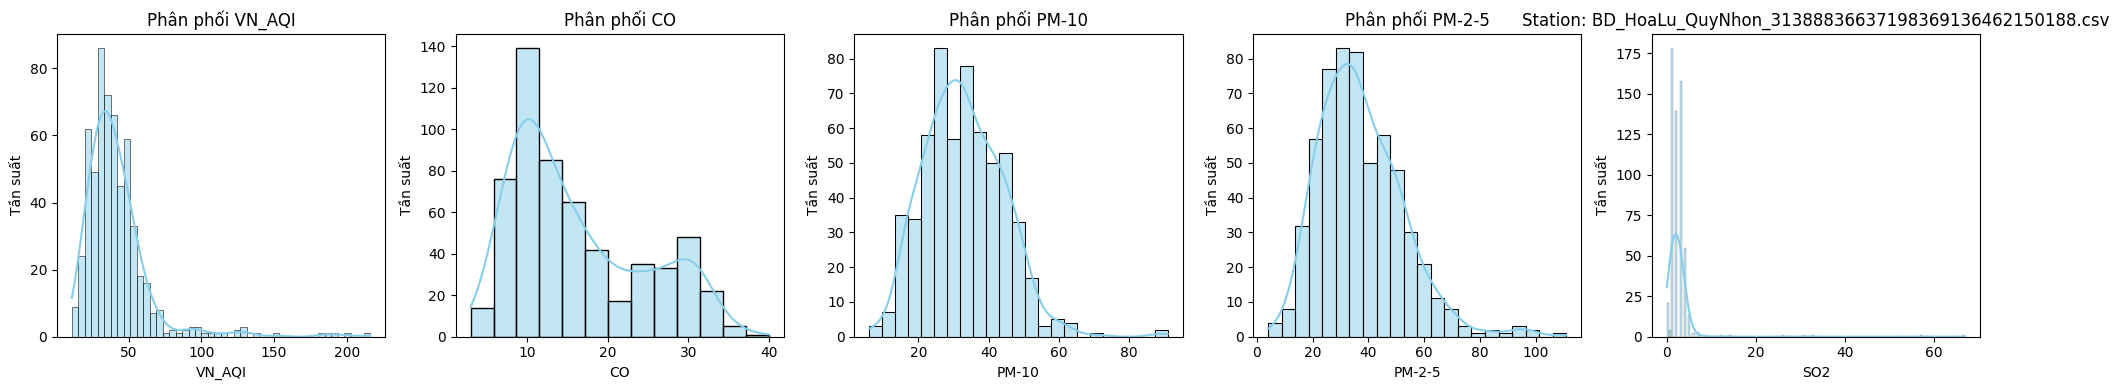

<Figure size 640x480 with 0 Axes>

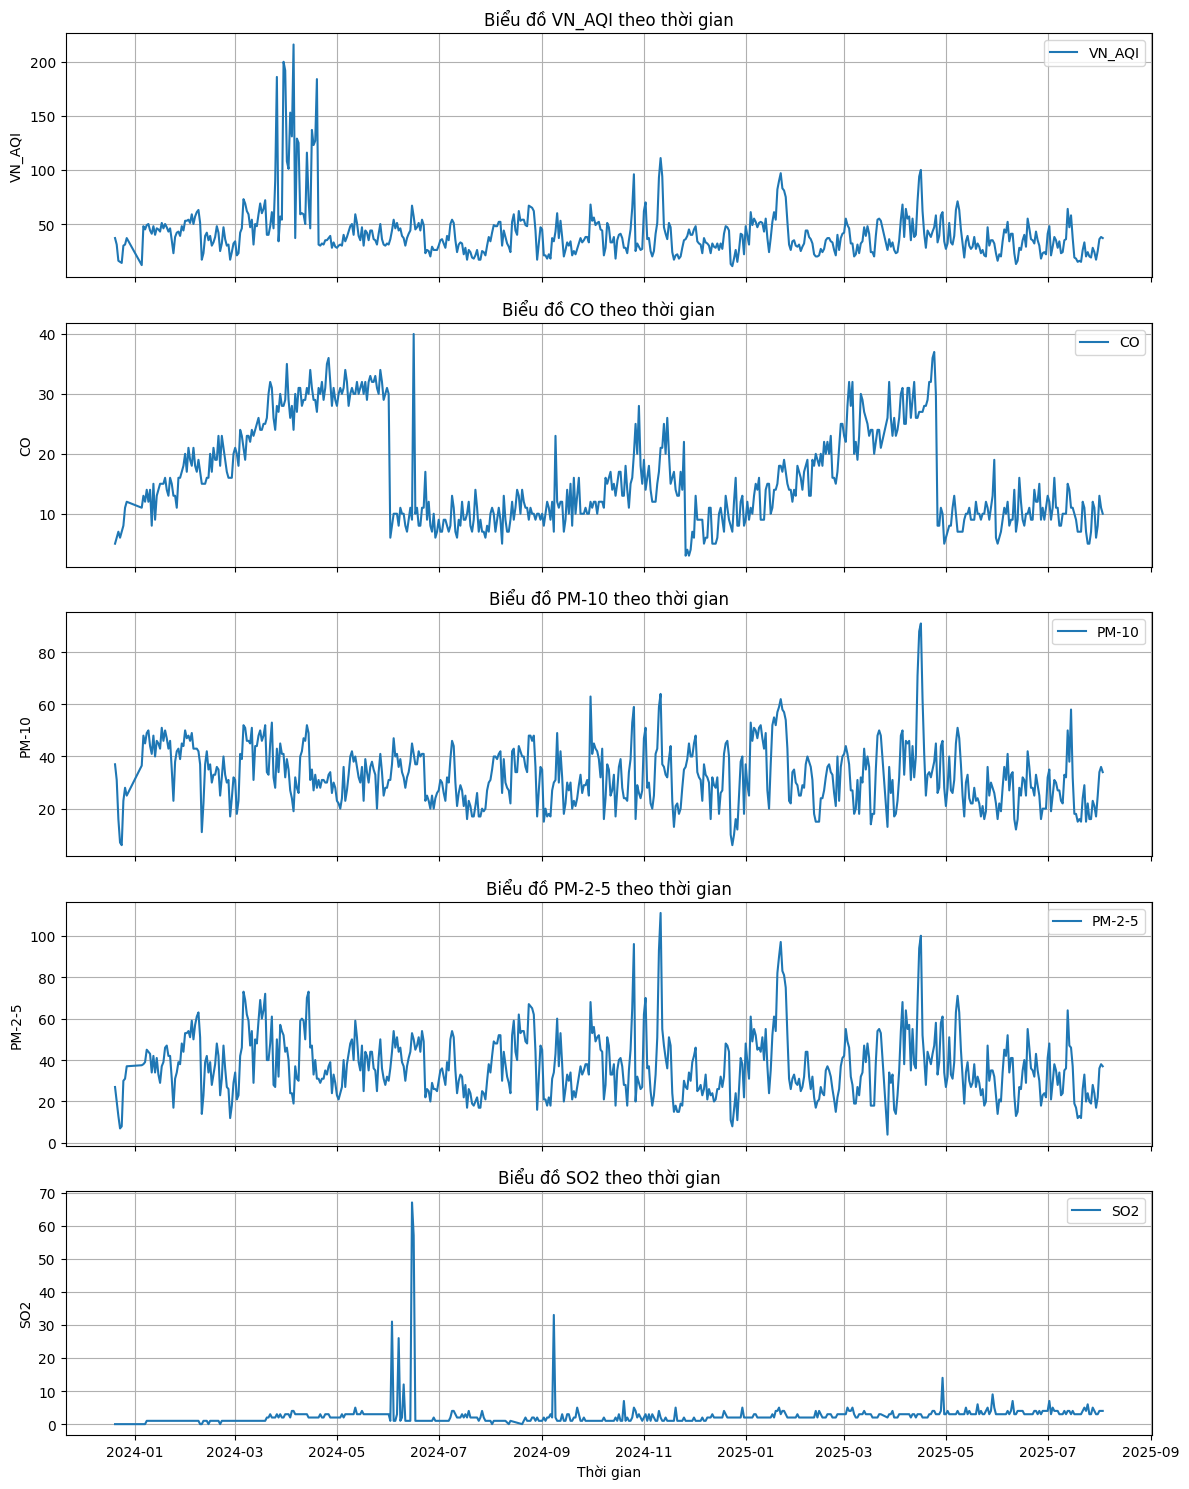

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
64            6    37.0  10.0   34.0    37.0  4.0  0.0  0.0  0.0  0.0  ...   
65            5    38.0  11.0   36.0    38.0  4.0  0.0  0.0  0.0  0.0  ...   
66            4    36.0  13.0   34.0    36.0  4.0  0.0  0.0  0.0  0.0  ...   
67            3    25.0   8.0   25.0    22.0  3.0  0.0  0.0  0.0  1.0  ...   
68            2    17.0   6.0   17.0    17.0  3.0  0.0  0.0  1.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
64     0.0     0.0     0.0  1.0   0.0   -0.029551 -0.693290   0.249386   
65     0.0     0.0     0.0  1.0   0.0    0.031203 -0.510763   0.406849   
66     0.0     0.0     0.0  1.0   0.0   -0.091925 -0.187394   0.249386   
67     0.0     0.0     0.0  1.0   0.0   -0.917133 -1.114246  -0.592904   
68     0.0     0.0     0.0  1.0   0.0   -1.777198 -1.641439  -1.634886   

    PM-2-5_log   SO2_log  
64    0.167947  1.034586  
65    0.231775  1.034586  
66   

<Figure size 640x480 with 0 Axes>

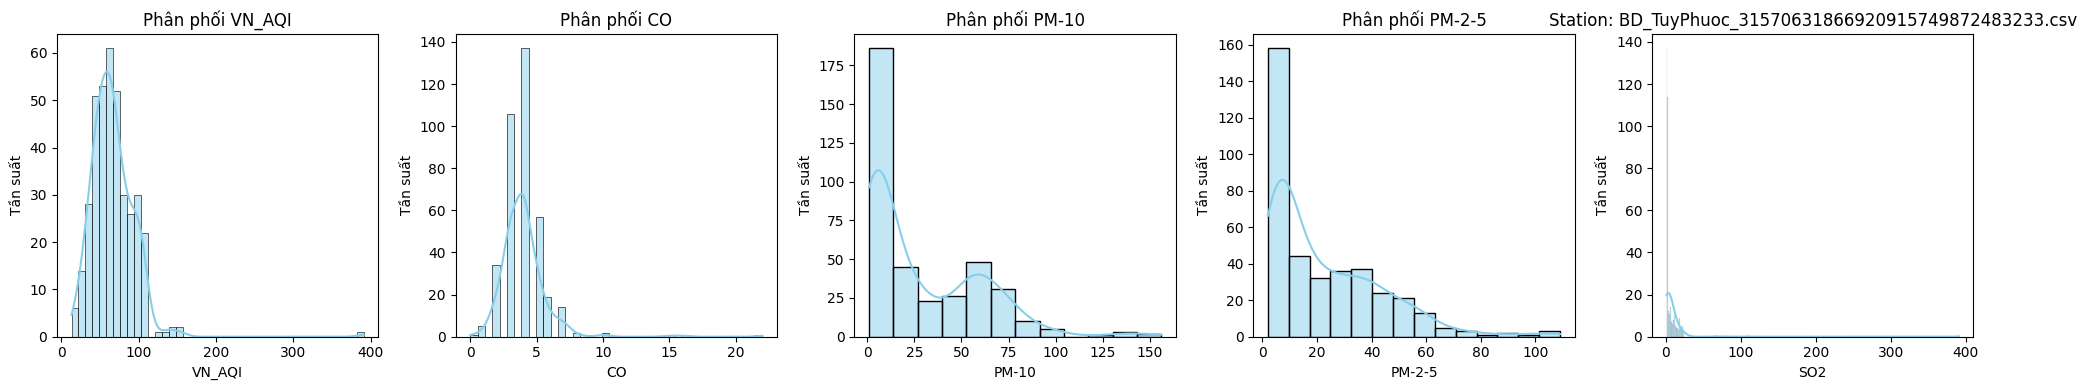

<Figure size 640x480 with 0 Axes>

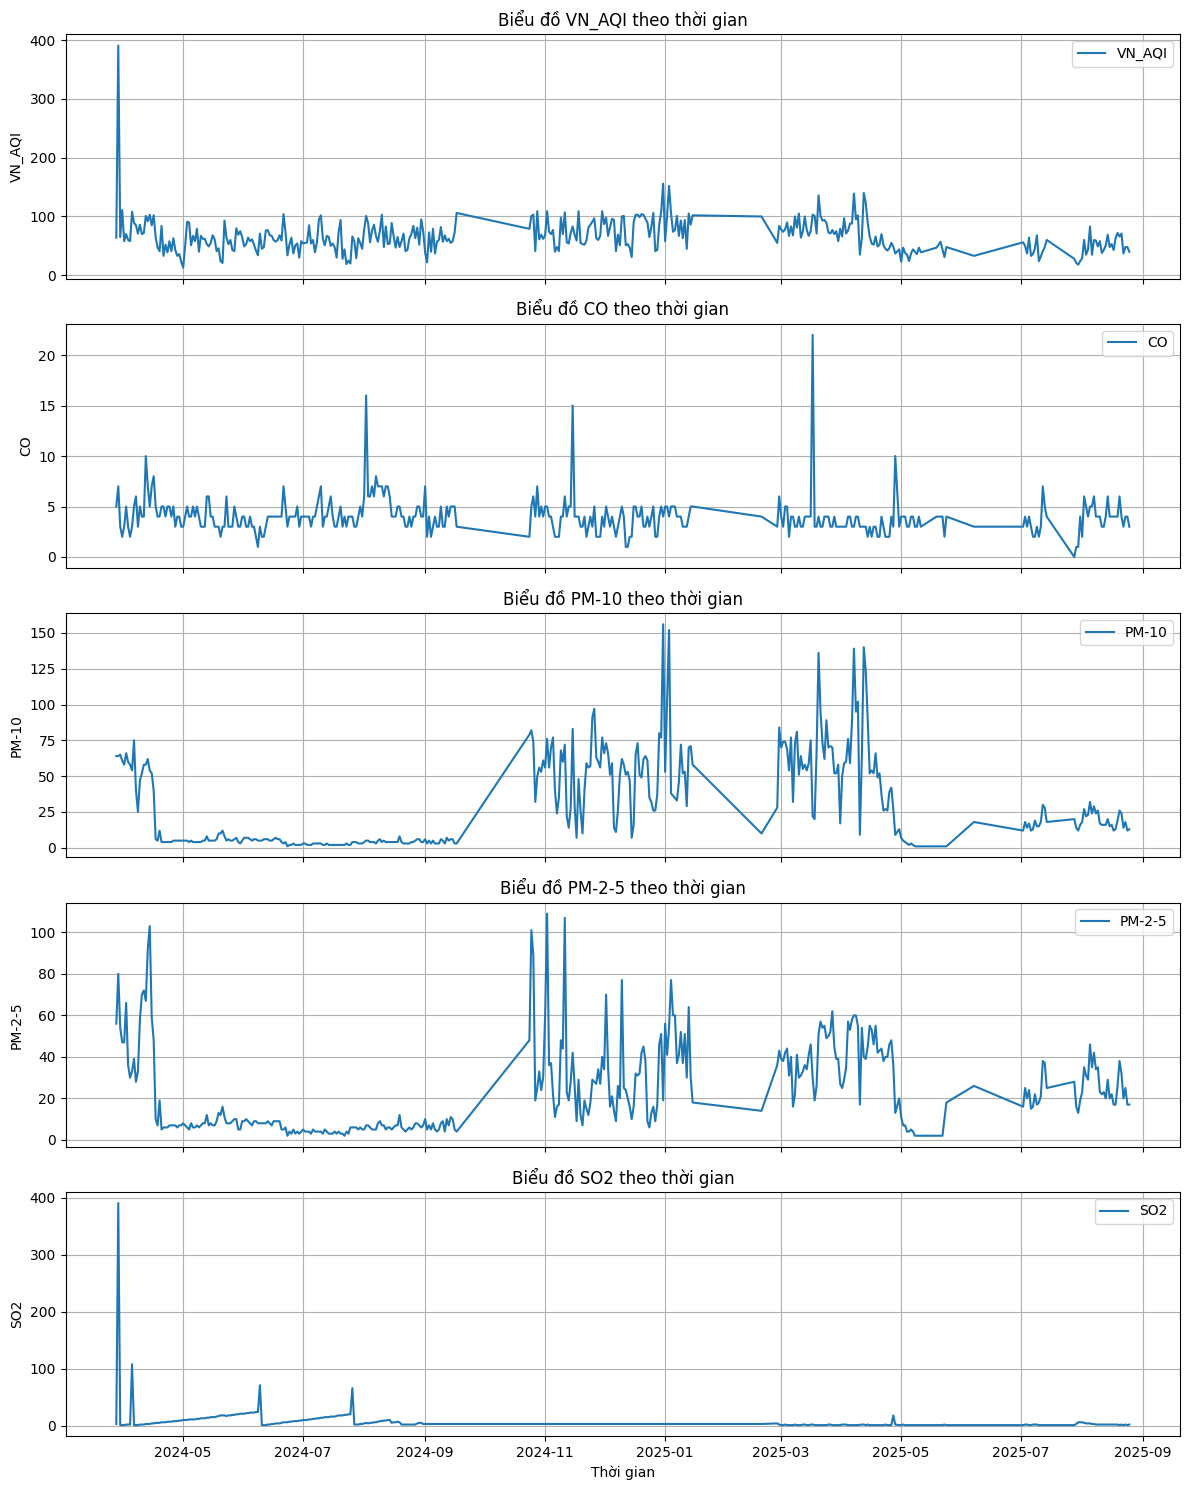

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
42            0    40.0  3.0   13.0    17.0  2.0  1.0  0.0  0.0  0.0  ...   
43            6    48.0  4.0   12.0    17.0  1.0  0.0  0.0  0.0  0.0  ...   
44            5    48.0  4.0   18.0    25.0  2.0  0.0  0.0  0.0  0.0  ...   
45            4    37.0  3.0   14.0    20.0  1.0  0.0  0.0  0.0  0.0  ...   
46            3    71.0  4.0   24.0    32.0  2.0  0.0  0.0  0.0  1.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
42     0.0     0.0     0.0  1.0   0.0   -1.045183 -0.591254  -0.103193   
43     0.0     0.0     0.0  1.0   0.0   -0.597928  0.150245  -0.164845   
44     0.0     0.0     0.0  1.0   0.0   -0.597928  0.150245   0.150862   
45     0.0     0.0     0.0  1.0   0.0   -1.235845 -0.591254  -0.045796   
46     0.0     0.0     0.0  1.0   0.0    0.367717  0.150245   0.379172   

    PM-2-5_log   SO2_log  
42    0.105854 -0.594108  
43    0.105854 -1.108884  
44    0.515

<Figure size 640x480 with 0 Axes>

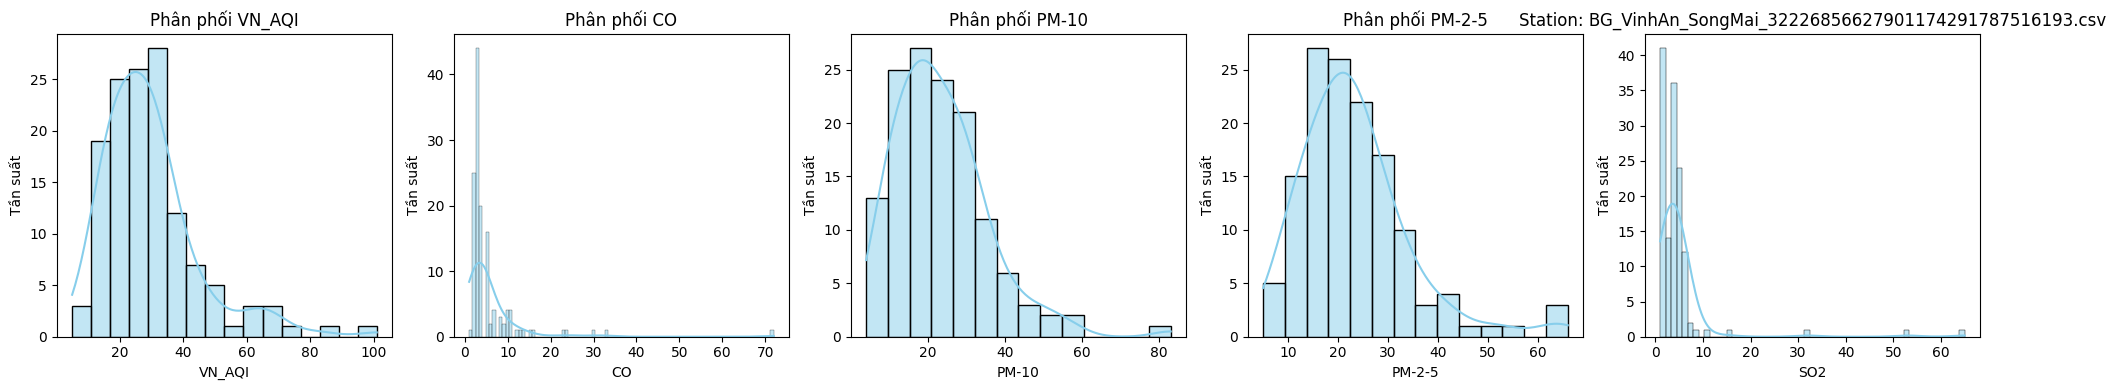

<Figure size 640x480 with 0 Axes>

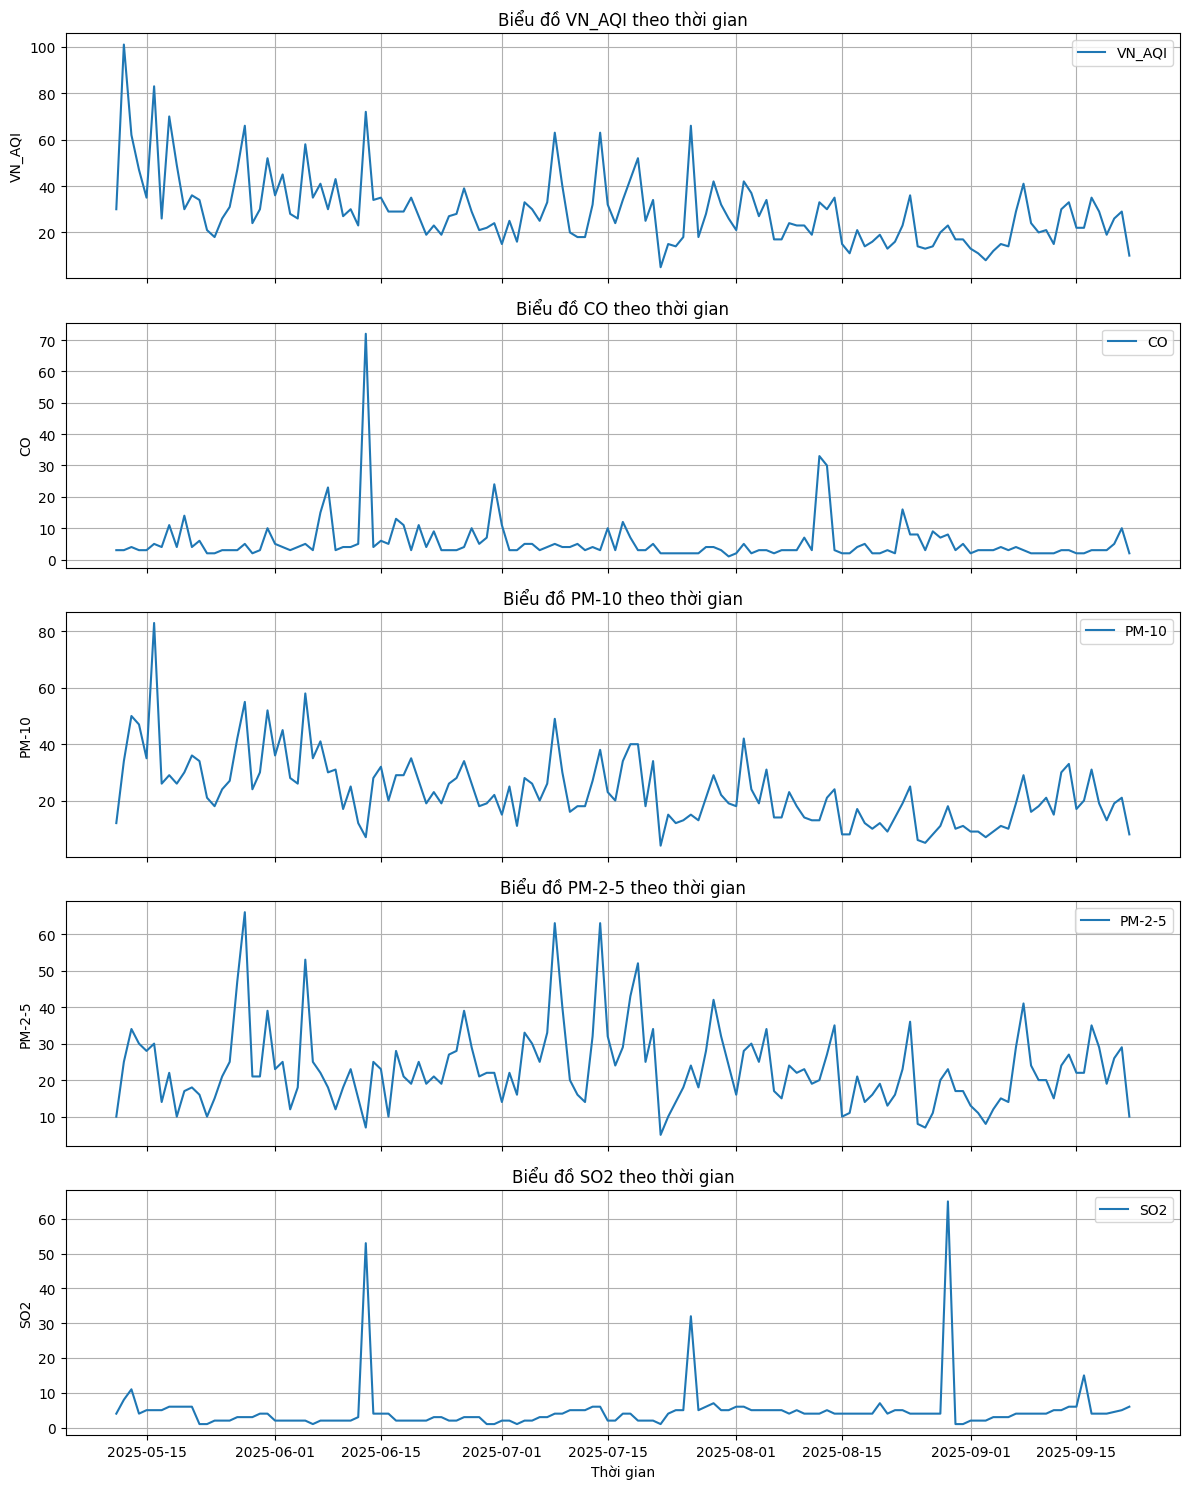

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
14            0    10.0   2.0    8.0    10.0  6.0  1.0  0.0  0.0  0.0  ...   
15            6    29.0  10.0   21.0    29.0  5.0  0.0  0.0  0.0  0.0  ...   
16            5    26.0   5.0   19.0    26.0  4.5  0.0  0.0  0.0  0.0  ...   
17            4    19.0   3.0   13.0    19.0  4.0  0.0  0.0  0.0  0.0  ...   
18            3    29.0   3.0   19.0    29.0  4.0  0.0  0.0  0.0  1.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
14     0.0     1.0     0.0  0.0   0.0   -1.981385 -0.987228  -1.737707   
15     0.0     1.0     0.0  0.0   0.0    0.197503  1.297156   0.037396   
16     0.0     1.0     0.0  0.0   0.0   -0.031310  0.231455  -0.151888   
17     0.0     1.0     0.0  0.0   0.0   -0.683052 -0.481429  -0.860237   
18     0.0     1.0     0.0  0.0   0.0    0.197503 -0.481429  -0.151888   

    PM-2-5_log   SO2_log  
14   -1.606627  0.770502  
15    0.698867  0.475758  
16   

<Figure size 640x480 with 0 Axes>

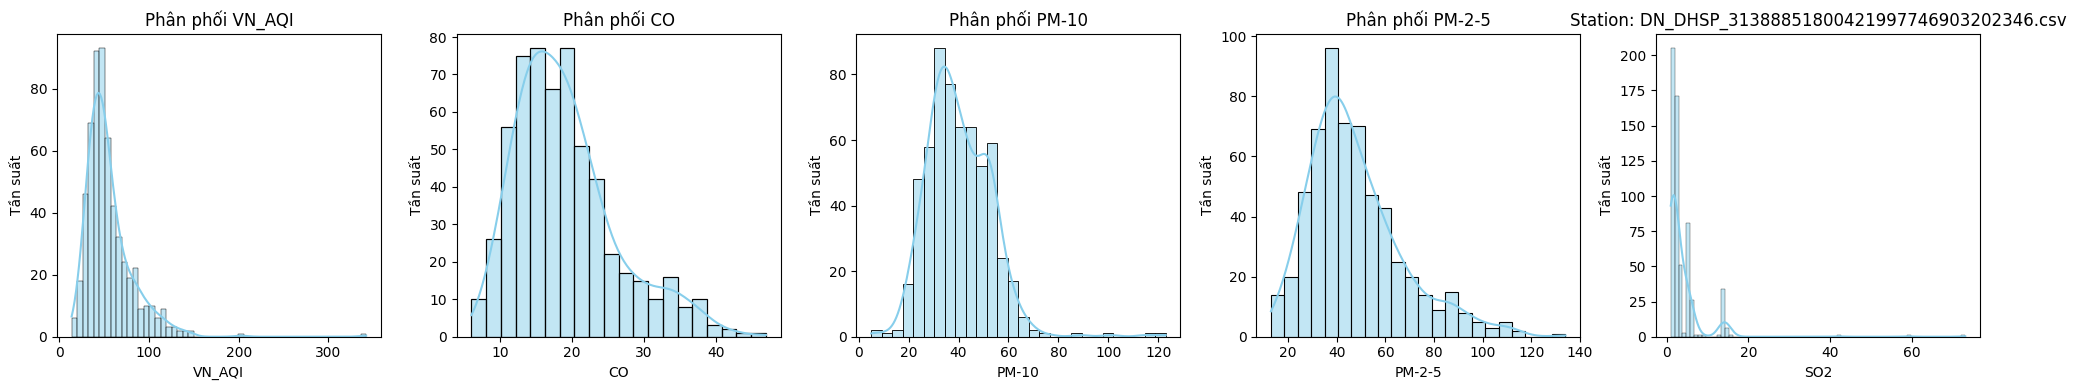

<Figure size 640x480 with 0 Axes>

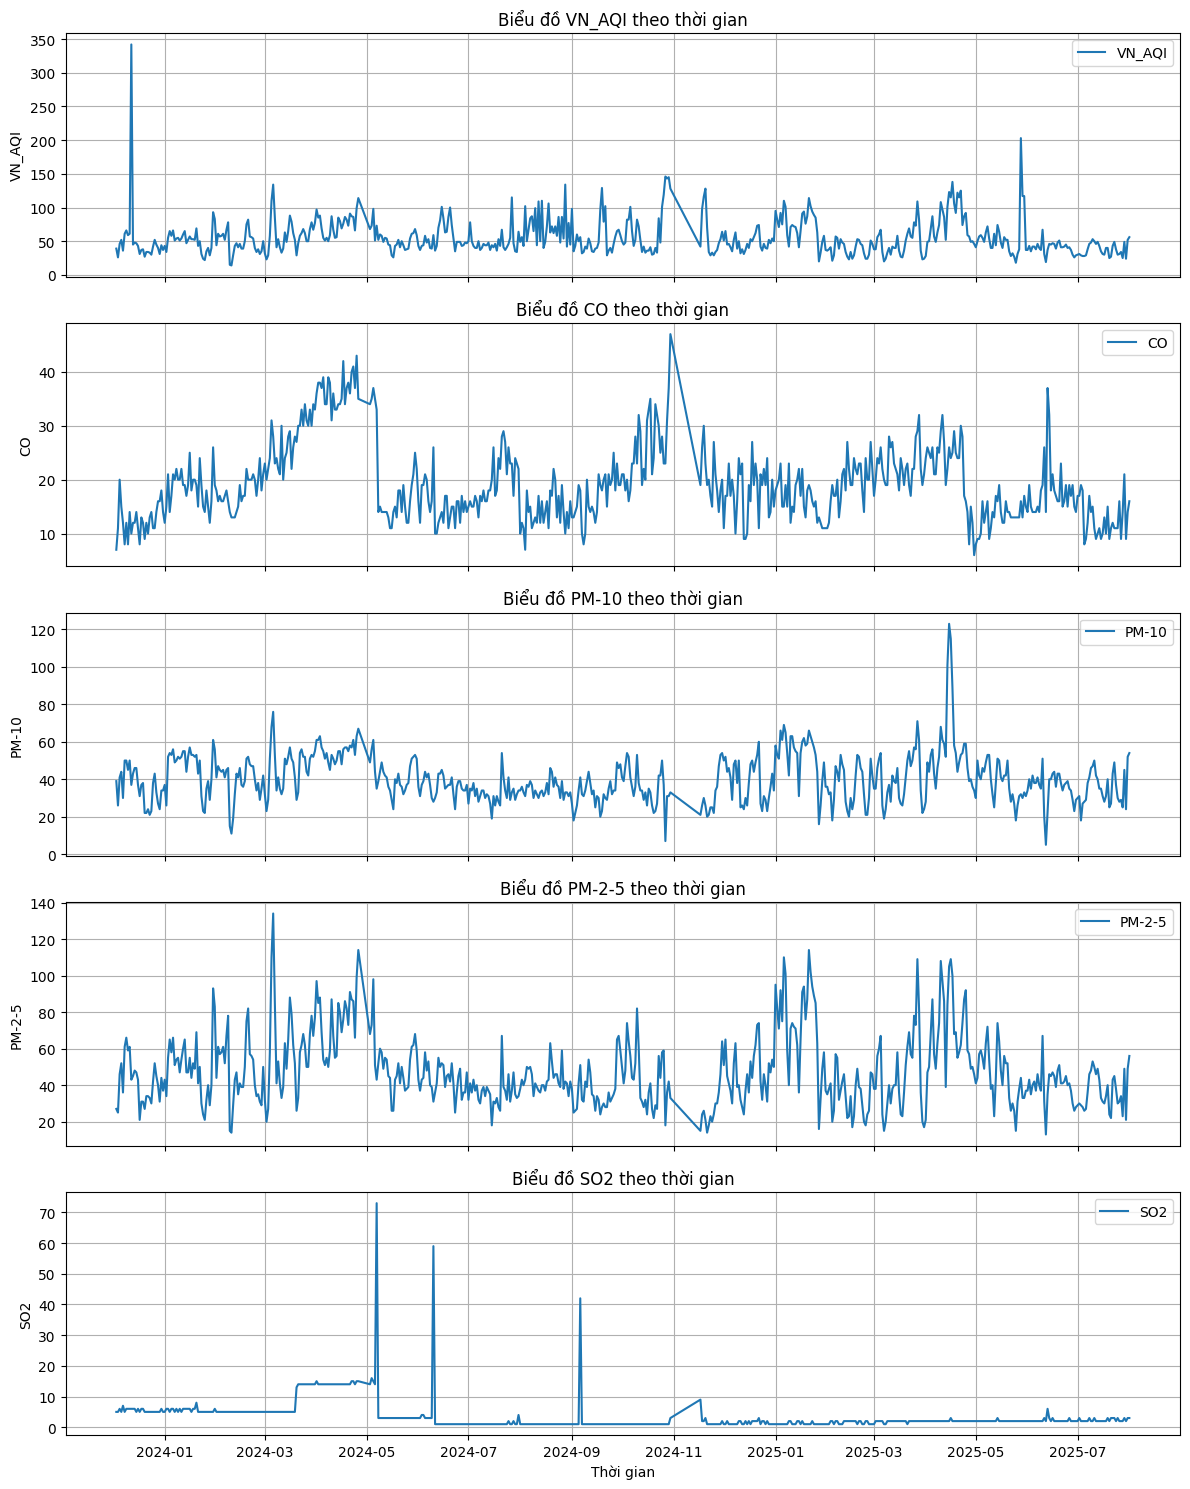

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
65            4    56.0  16.0   54.0    56.0  3.0  0.0  0.0  0.0  0.0  ...   
66            3    52.0  14.0   52.0    49.0  3.0  0.0  0.0  0.0  1.0  ...   
67            2    24.0   9.0   24.0    21.0  2.0  0.0  0.0  1.0  0.0  ...   
68            1    49.0  21.0   45.0    49.0  3.0  0.0  1.0  0.0  0.0  ...   
69            0    25.0  14.0   25.0    23.0  2.0  1.0  0.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
65     0.0     0.0     0.0  1.0   0.0    0.228796 -0.329897   1.065291   
66     0.0     0.0     0.0  1.0   0.0    0.048799 -0.699815   0.947756   
67     0.0     0.0     0.0  1.0   0.0   -1.810107 -1.898162  -1.436558   
68     0.0     0.0     0.0  1.0   0.0   -0.095351  0.432114   0.498285   
69     0.0     0.0     0.0  1.0   0.0   -1.713081 -0.699815  -1.312107   

    PM-2-5_log   SO2_log  
65    0.603695  0.213142  
66    0.268491  0.213142  
67   

<Figure size 640x480 with 0 Axes>

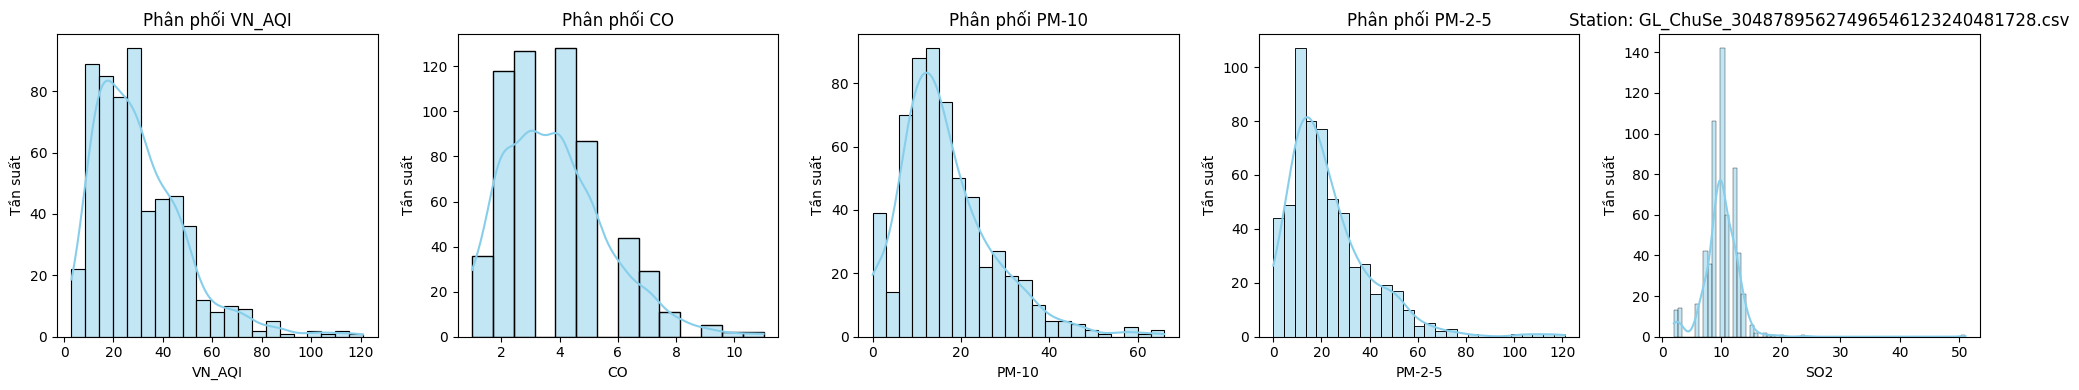

<Figure size 640x480 with 0 Axes>

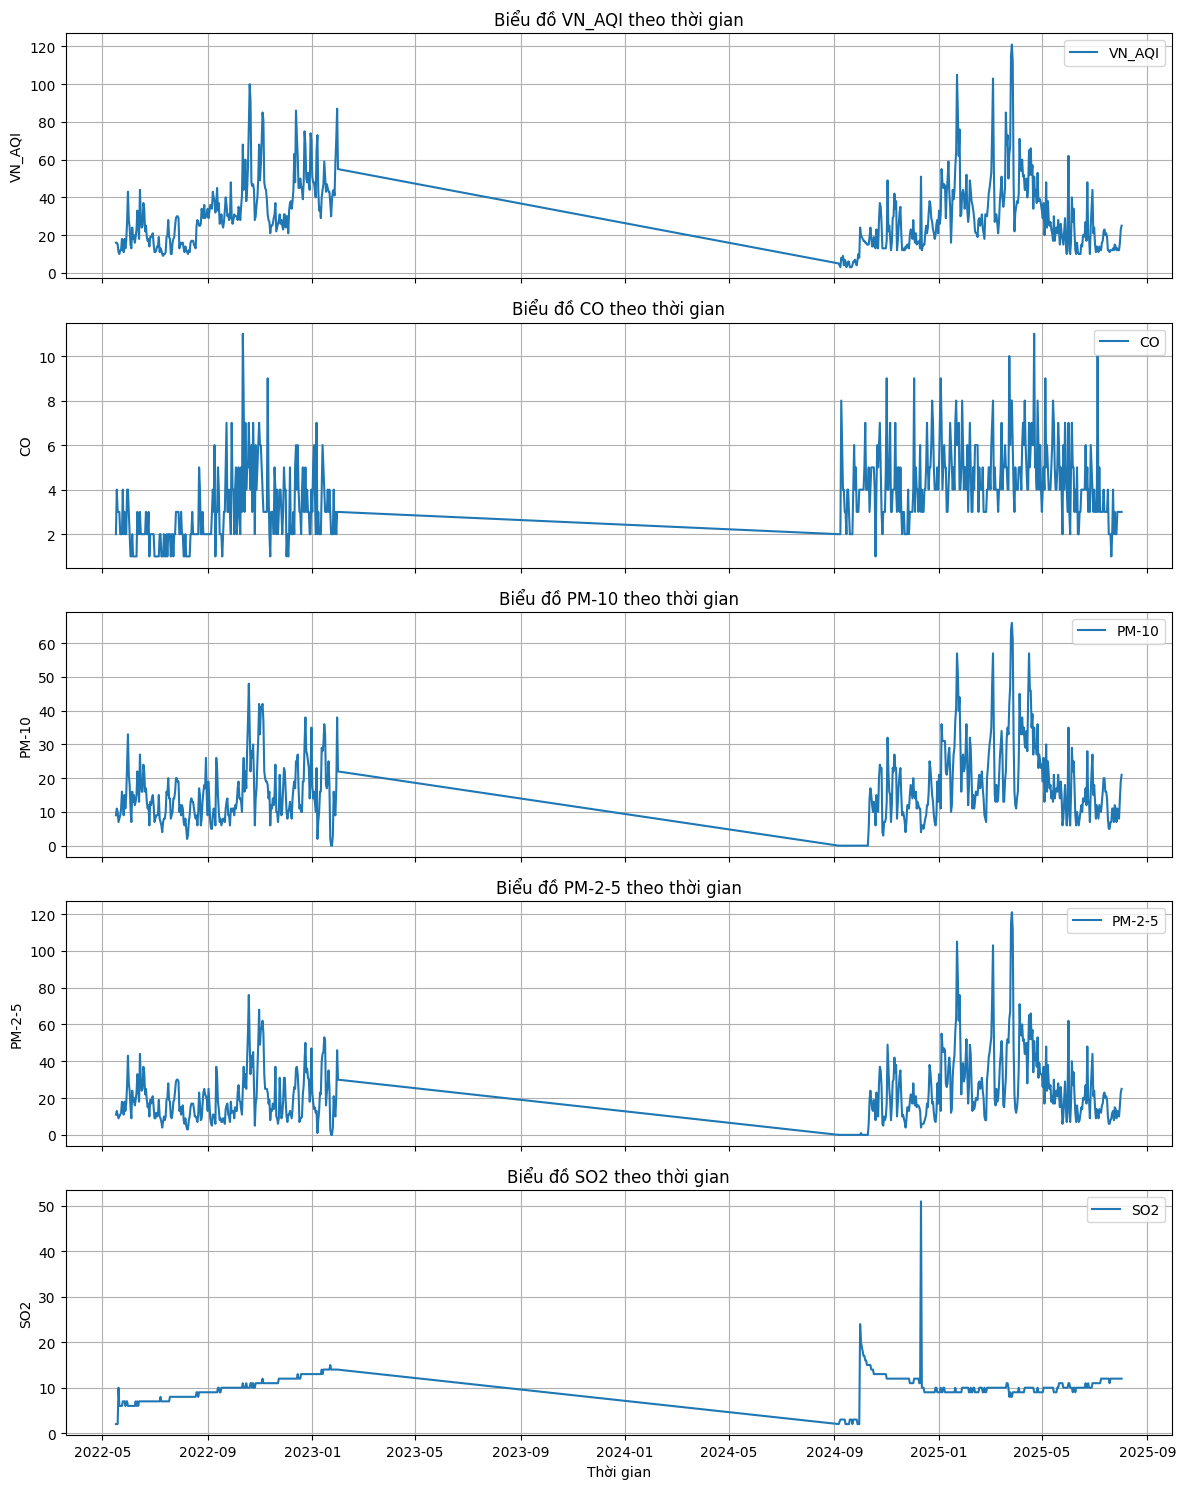

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5   SO2  mon   tu  wed  thu  ...  \
65            5    25.0  3.0   21.0    25.0  12.0  0.0  0.0  0.0  0.0  ...   
66            4    23.0  3.0   19.0    23.0  12.0  0.0  0.0  0.0  0.0  ...   
67            3    16.0  3.0   14.0    16.0  12.0  0.0  0.0  0.0  1.0  ...   
68            2    12.0  3.0    8.0    10.0  12.0  0.0  0.0  1.0  0.0  ...   
69            1    12.0  3.0   10.0    12.0  12.0  0.0  1.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
65     0.0     0.0     0.0  1.0   0.0   -0.038275 -0.303606   0.568492   
66     0.0     0.0     0.0  1.0   0.0   -0.172712 -0.303606   0.455130   
67     0.0     0.0     0.0  1.0   0.0   -0.751892 -0.303606   0.112961   
68     0.0     0.0     0.0  1.0   0.0   -1.202458 -0.303606  -0.494616   
69     0.0     0.0     0.0  1.0   0.0   -1.202458 -0.303606  -0.255938   

    PM-2-5_log   SO2_log  
65    0.438342  0.667856  
66    0.353584  0.667856  
67   

<Figure size 640x480 with 0 Axes>

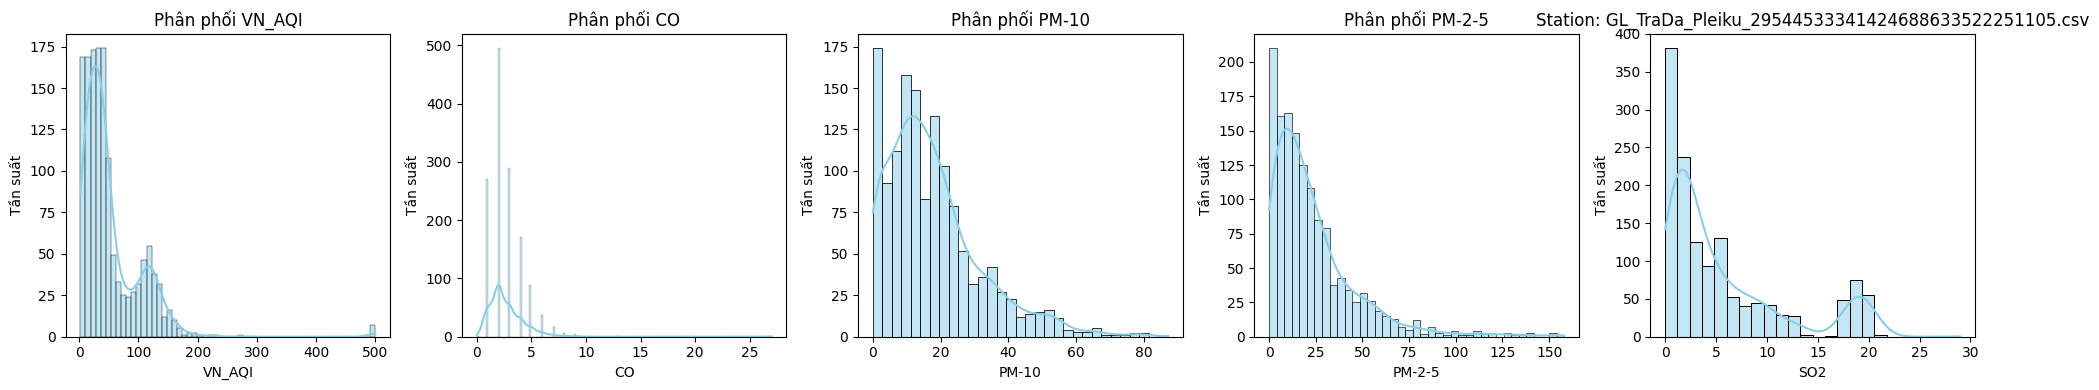

<Figure size 640x480 with 0 Axes>

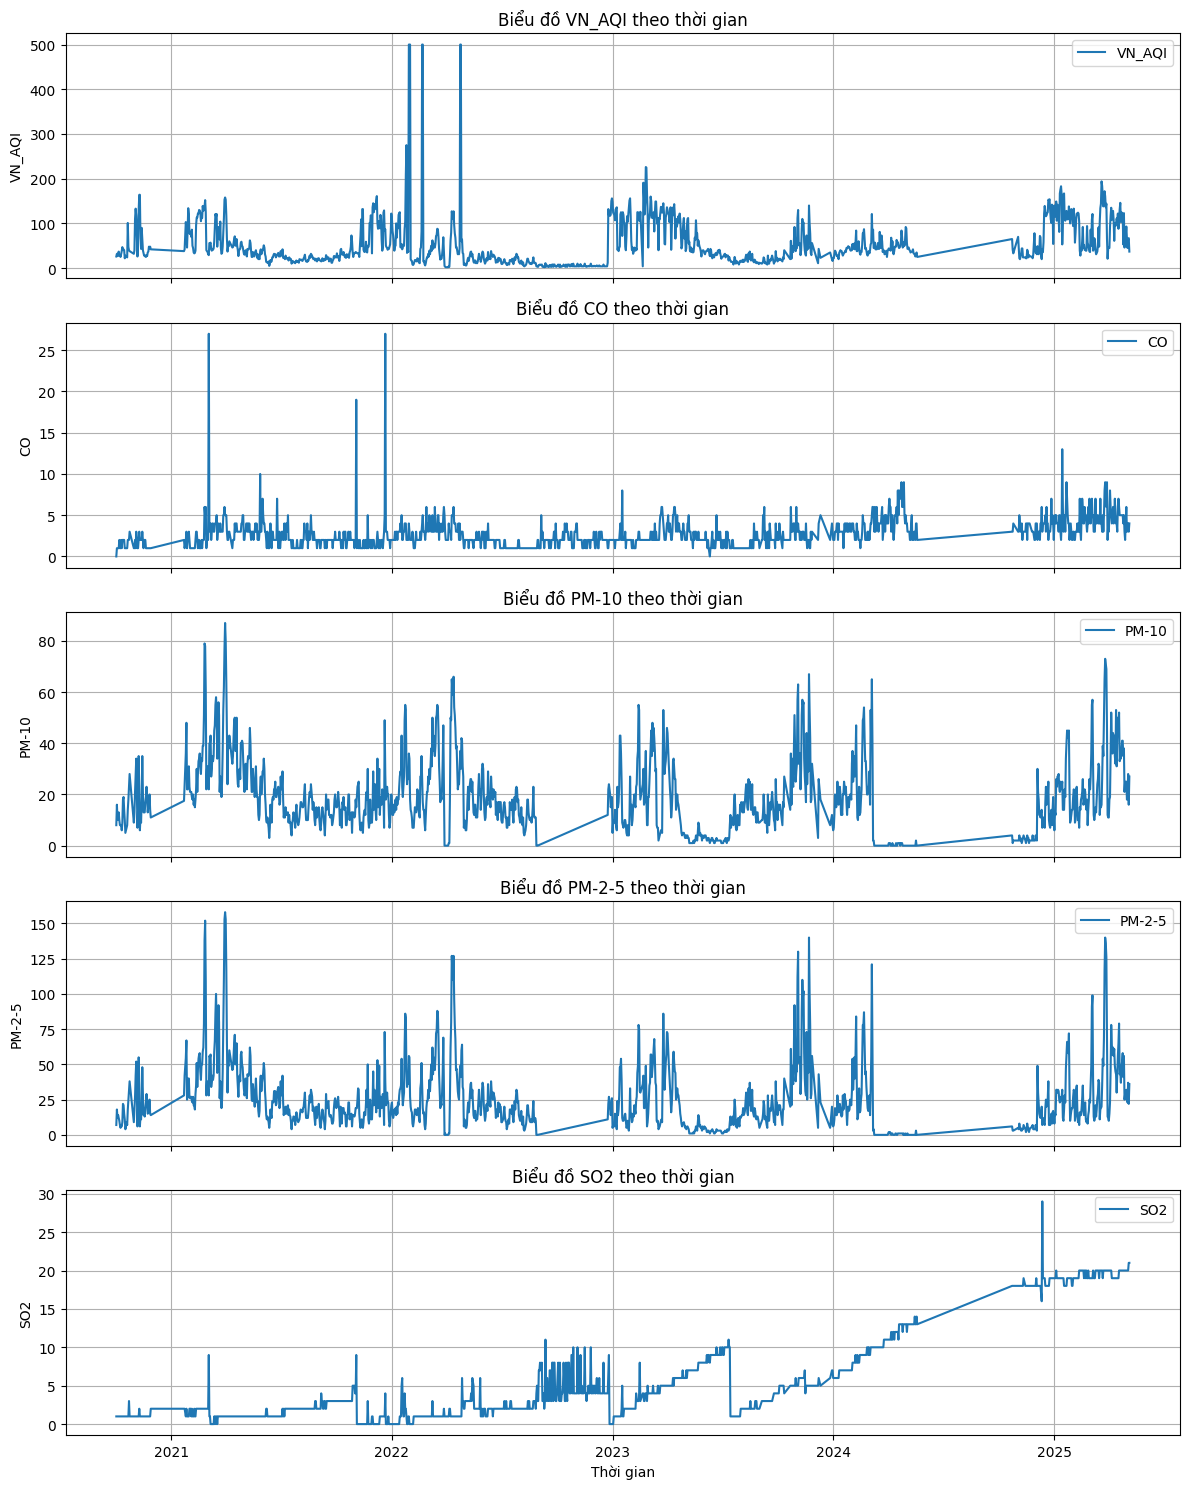

     Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5   SO2  mon   tu  wed  thu  ...  \
154            0    37.0  4.0   27.0    36.0  21.0  1.0  0.0  0.0  0.0  ...   
155            6    67.0  3.0   16.0    22.0  21.0  0.0  0.0  0.0  0.0  ...   
156            5    66.0  4.0   28.0    37.0  20.0  0.0  0.0  0.0  0.0  ...   
157            4    45.0  4.0   19.0    23.0  20.0  0.0  0.0  0.0  0.0  ...   
158            3    66.0  3.0   18.0    25.0  20.0  0.0  0.0  0.0  1.0  ...   

     summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
154     0.0     0.0     0.0  1.0   0.0    0.068269  0.964986   0.786282   
155     0.0     0.0     0.0  1.0   0.0    0.683426  0.387979   0.278191   
156     0.0     0.0     0.0  1.0   0.0    0.667765  0.964986   0.822014   
157     0.0     0.0     0.0  1.0   0.0    0.270236  0.964986   0.443674   
158     0.0     0.0     0.0  1.0   0.0    0.667765  0.387979   0.391445   

     PM-2-5_log   SO2_log  
154    0.824184  1.819148  
155    0.380085  1

<Figure size 640x480 with 0 Axes>

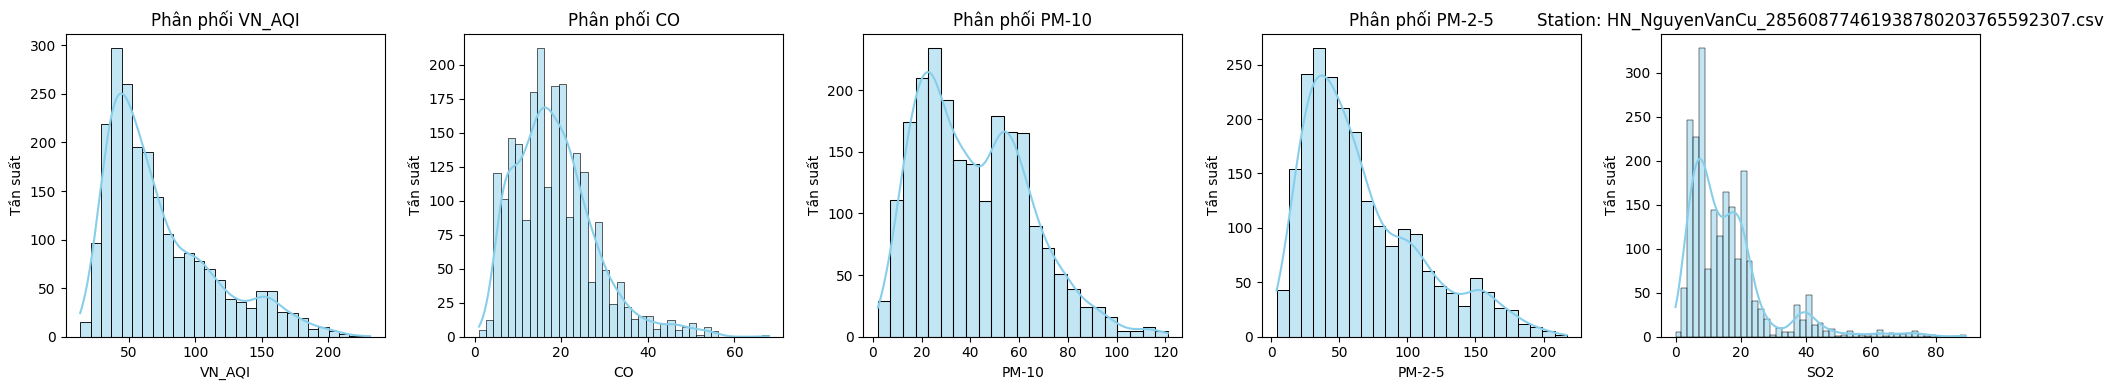

<Figure size 640x480 with 0 Axes>

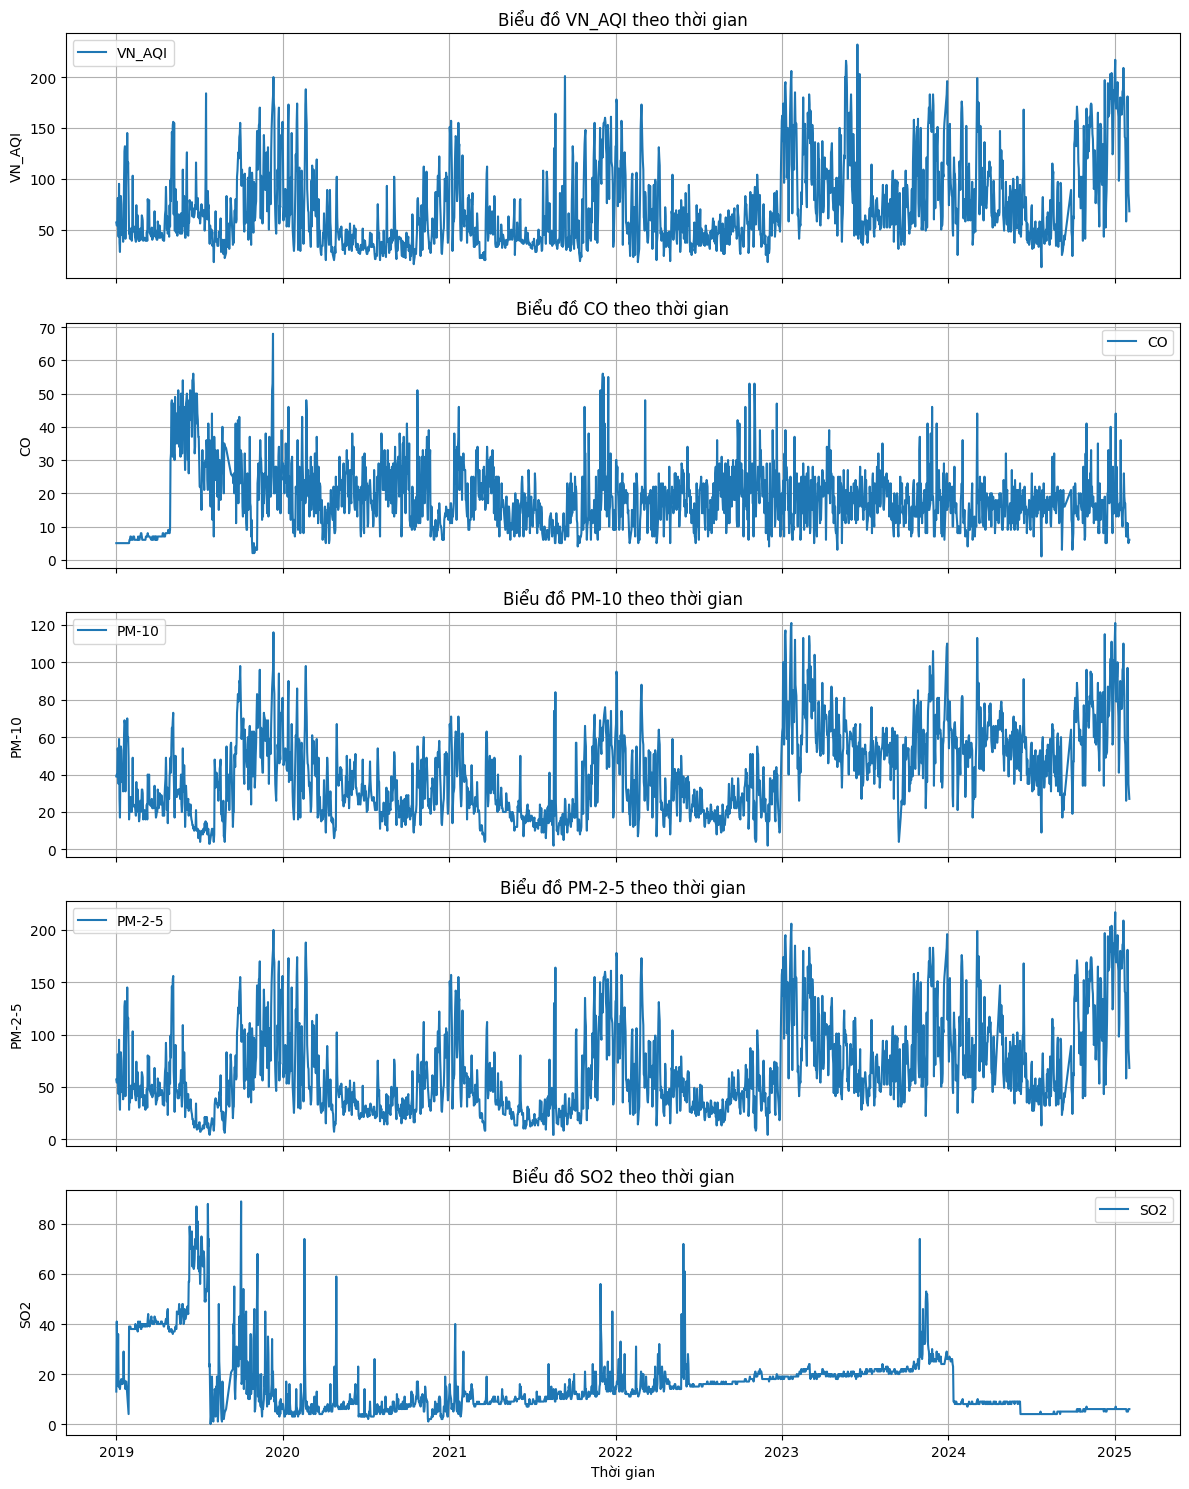

     Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
243            6    68.0   6.0   27.0    68.0  6.0  0.0  0.0  0.0  0.0  ...   
244            5    79.0   6.0   31.0    79.0  6.0  0.0  0.0  0.0  0.0  ...   
245            4    86.0   5.0   35.0    86.0  6.0  0.0  0.0  0.0  0.0  ...   
246            3   151.0   8.0   68.0   151.0  5.0  0.0  0.0  0.0  1.0  ...   
247            2   181.0  11.0   97.0   181.0  5.0  0.0  0.0  1.0  0.0  ...   

     summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
243     0.0     0.0     0.0  0.0   0.0    0.129574 -1.817020  -0.431490   
244     0.0     0.0     0.0  0.0   0.0    0.413945 -1.817020  -0.209365   
245     0.0     0.0     0.0  0.0   0.0    0.575204 -2.124910  -0.013437   
246     0.0     0.0     0.0  0.0   0.0    1.647884 -1.315061   1.068793   
247     0.0     0.0     0.0  0.0   0.0    1.994170 -0.740463   1.652438   

     PM-2-5_log   SO2_log  
243    0.335250 -1.000382  
244    0.557560 -1

<Figure size 640x480 with 0 Axes>

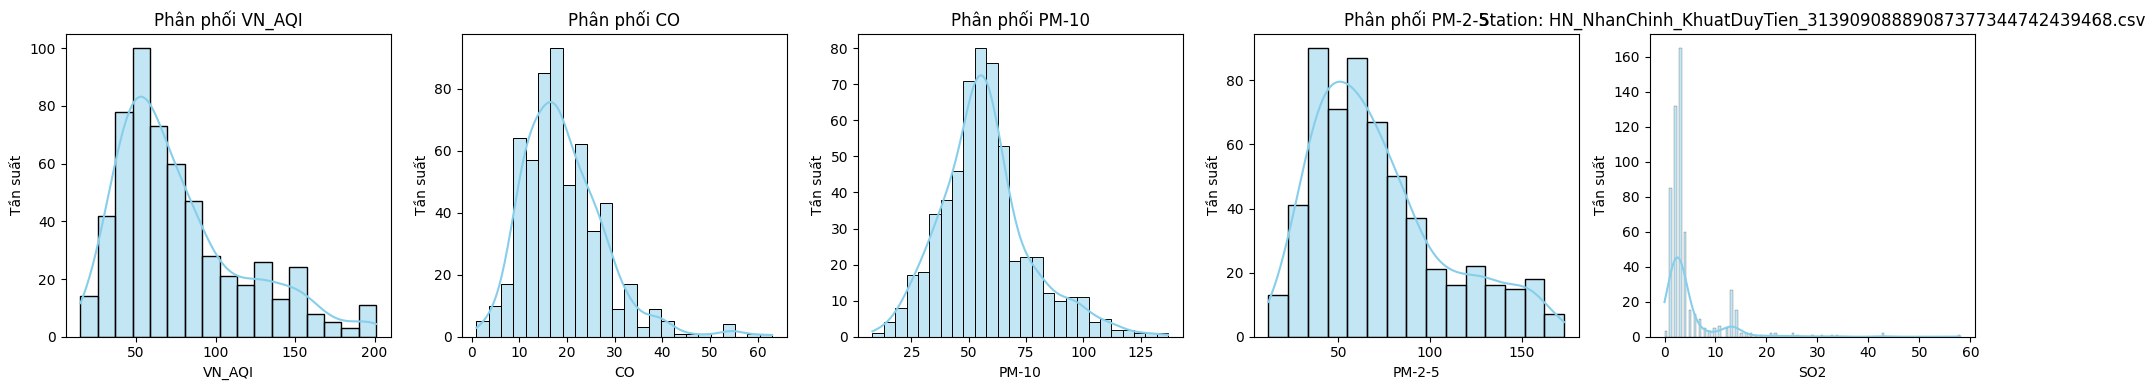

<Figure size 640x480 with 0 Axes>

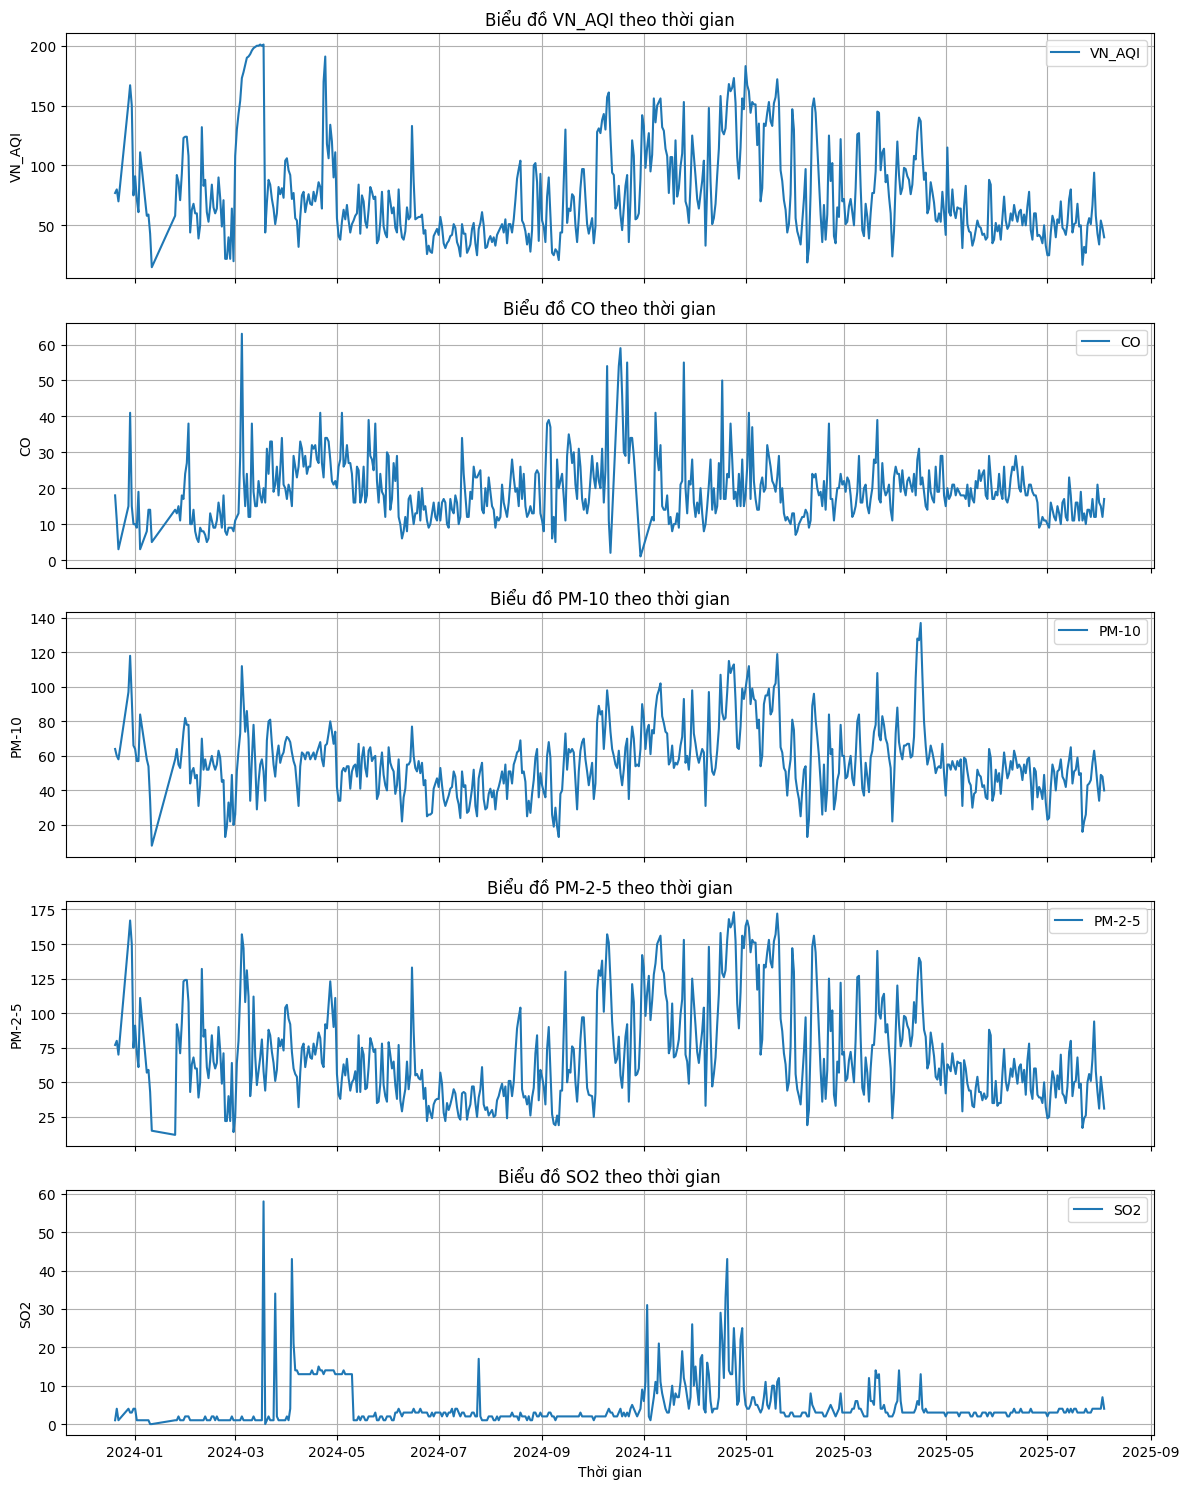

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
63            0    40.0  17.0   40.0    31.0  4.0  1.0  0.0  0.0  0.0  ...   
64            6    48.0  12.0   48.0    43.0  7.0  0.0  0.0  0.0  0.0  ...   
65            5    54.0  15.0   49.0    54.0  4.0  0.0  0.0  0.0  0.0  ...   
66            4    34.0  16.0   34.0    31.0  4.0  0.0  0.0  0.0  0.0  ...   
67            3    43.0  21.0   43.0    43.0  4.0  0.0  0.0  0.0  1.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
63     0.0     1.0     0.0  0.0   0.0   -1.064828 -0.065845  -0.802232   
64     0.0     1.0     0.0  0.0   0.0   -0.703918 -0.808699  -0.308299   
65     0.0     1.0     0.0  0.0   0.0   -0.470033 -0.334713  -0.252317   
66     0.0     1.0     0.0  0.0   0.0   -1.385193 -0.196323  -1.240676   
67     0.0     1.0     0.0  0.0   0.0   -0.921844  0.392233  -0.606548   

    PM-2-5_log   SO2_log  
63   -1.413084  0.207694  
64   -0.772372  0.936339  
65   

<Figure size 640x480 with 0 Axes>

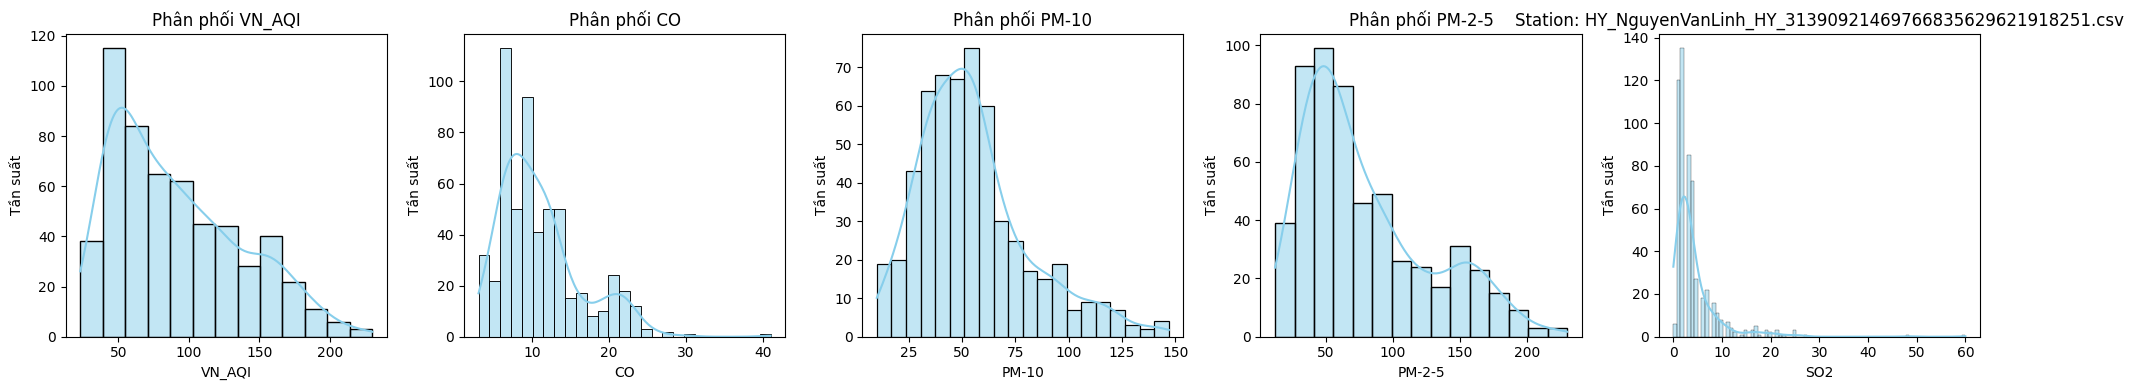

<Figure size 640x480 with 0 Axes>

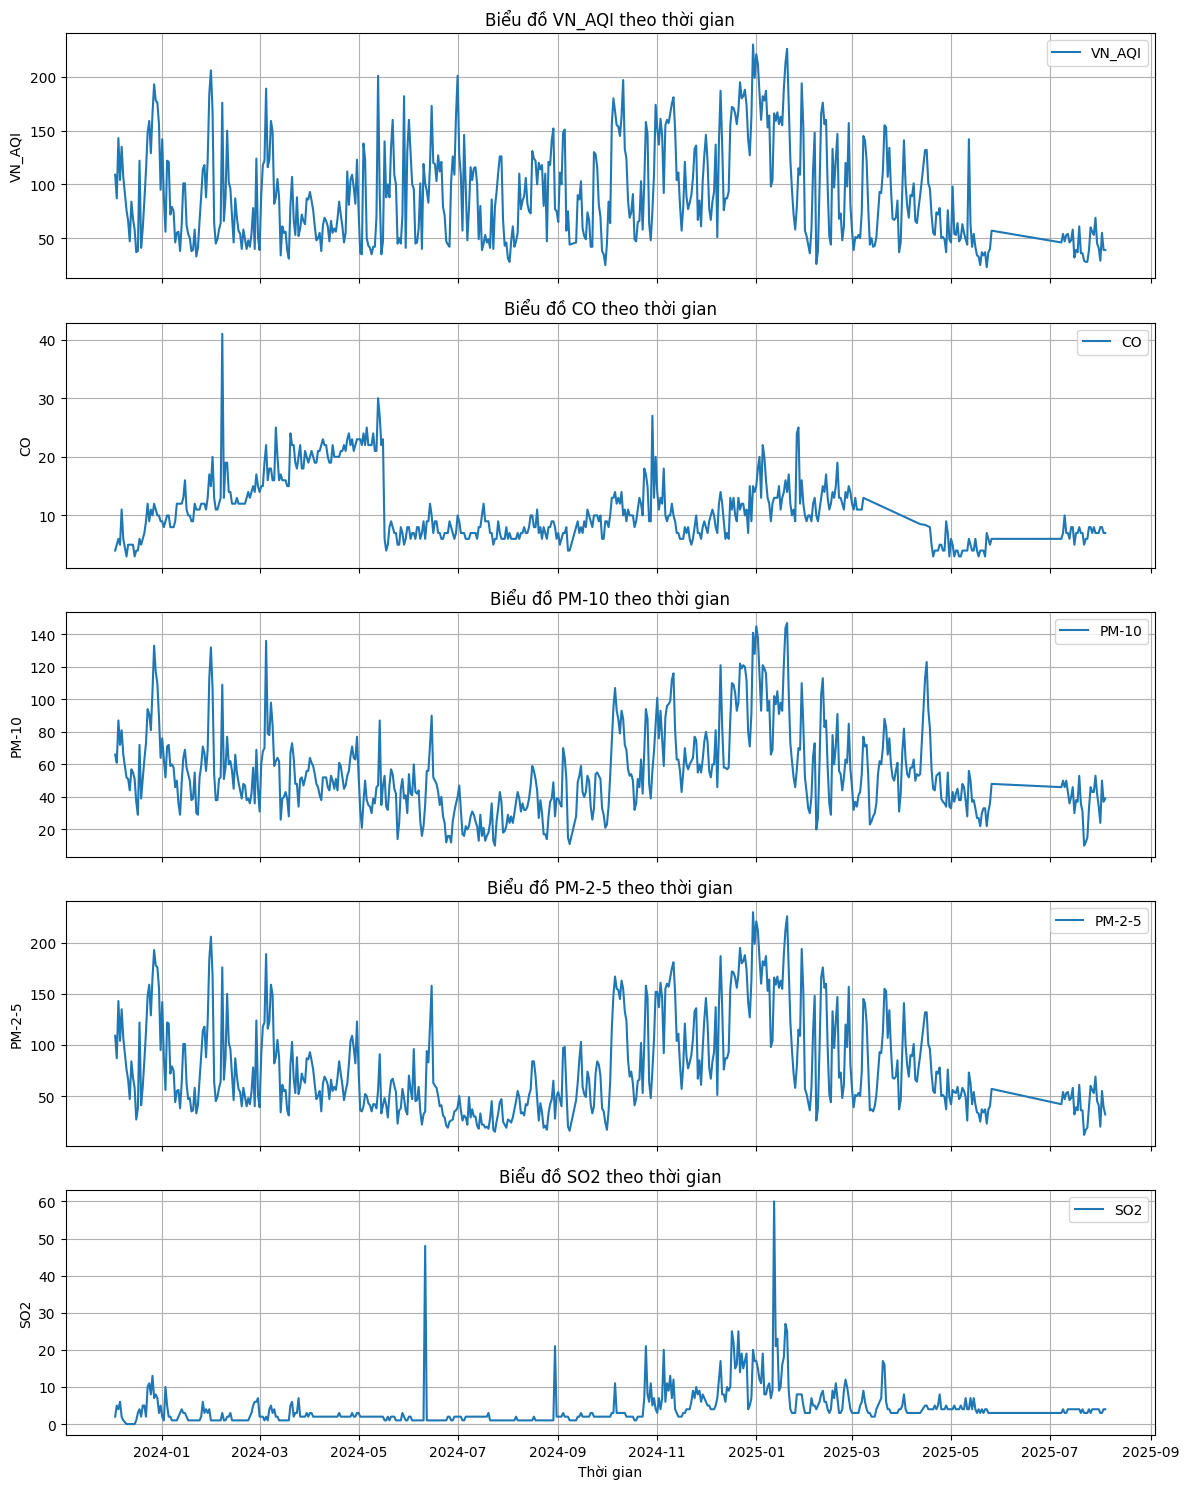

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
62            0    39.0  7.0   39.0    32.0  4.0  1.0  0.0  0.0  0.0  ...   
63            6    39.0  7.0   37.0    39.0  4.0  0.0  0.0  0.0  0.0  ...   
64            5    55.0  8.0   50.0    55.0  3.0  0.0  0.0  0.0  0.0  ...   
65            4    29.0  8.0   24.0    20.0  3.0  0.0  0.0  0.0  0.0  ...   
66            3    41.0  7.0   34.0    41.0  4.0  0.0  0.0  0.0  1.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
62     0.0     1.0     0.0  0.0   0.0   -1.418278 -0.729670  -0.486437   
63     0.0     1.0     0.0  0.0   0.0   -1.418278 -0.729670  -0.593886   
64     0.0     1.0     0.0  0.0   0.0   -0.748198 -0.453627   0.022490   
65     0.0     1.0     0.0  0.0   0.0   -1.991193 -0.453627  -1.471005   
66     0.0     1.0     0.0  0.0   0.0   -1.321113 -0.729670  -0.766159   

    PM-2-5_log   SO2_log  
62   -1.204217  0.300537  
63   -0.879962  0.300537  
64   -0.312

<Figure size 640x480 with 0 Axes>

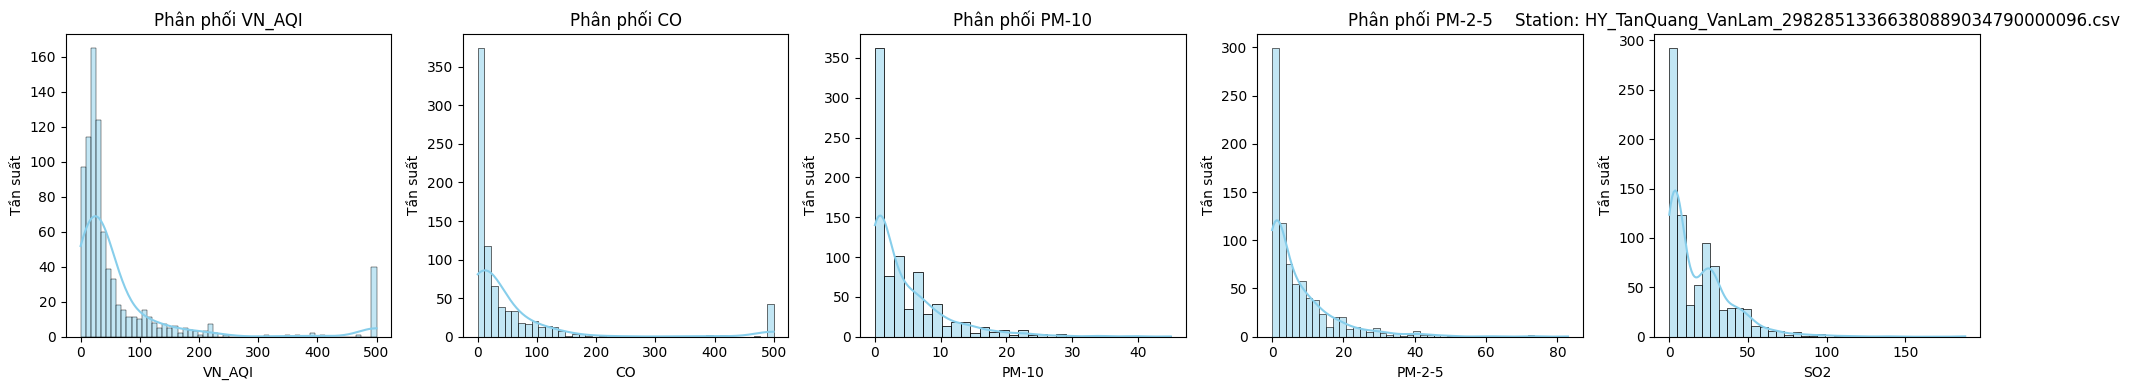

<Figure size 640x480 with 0 Axes>

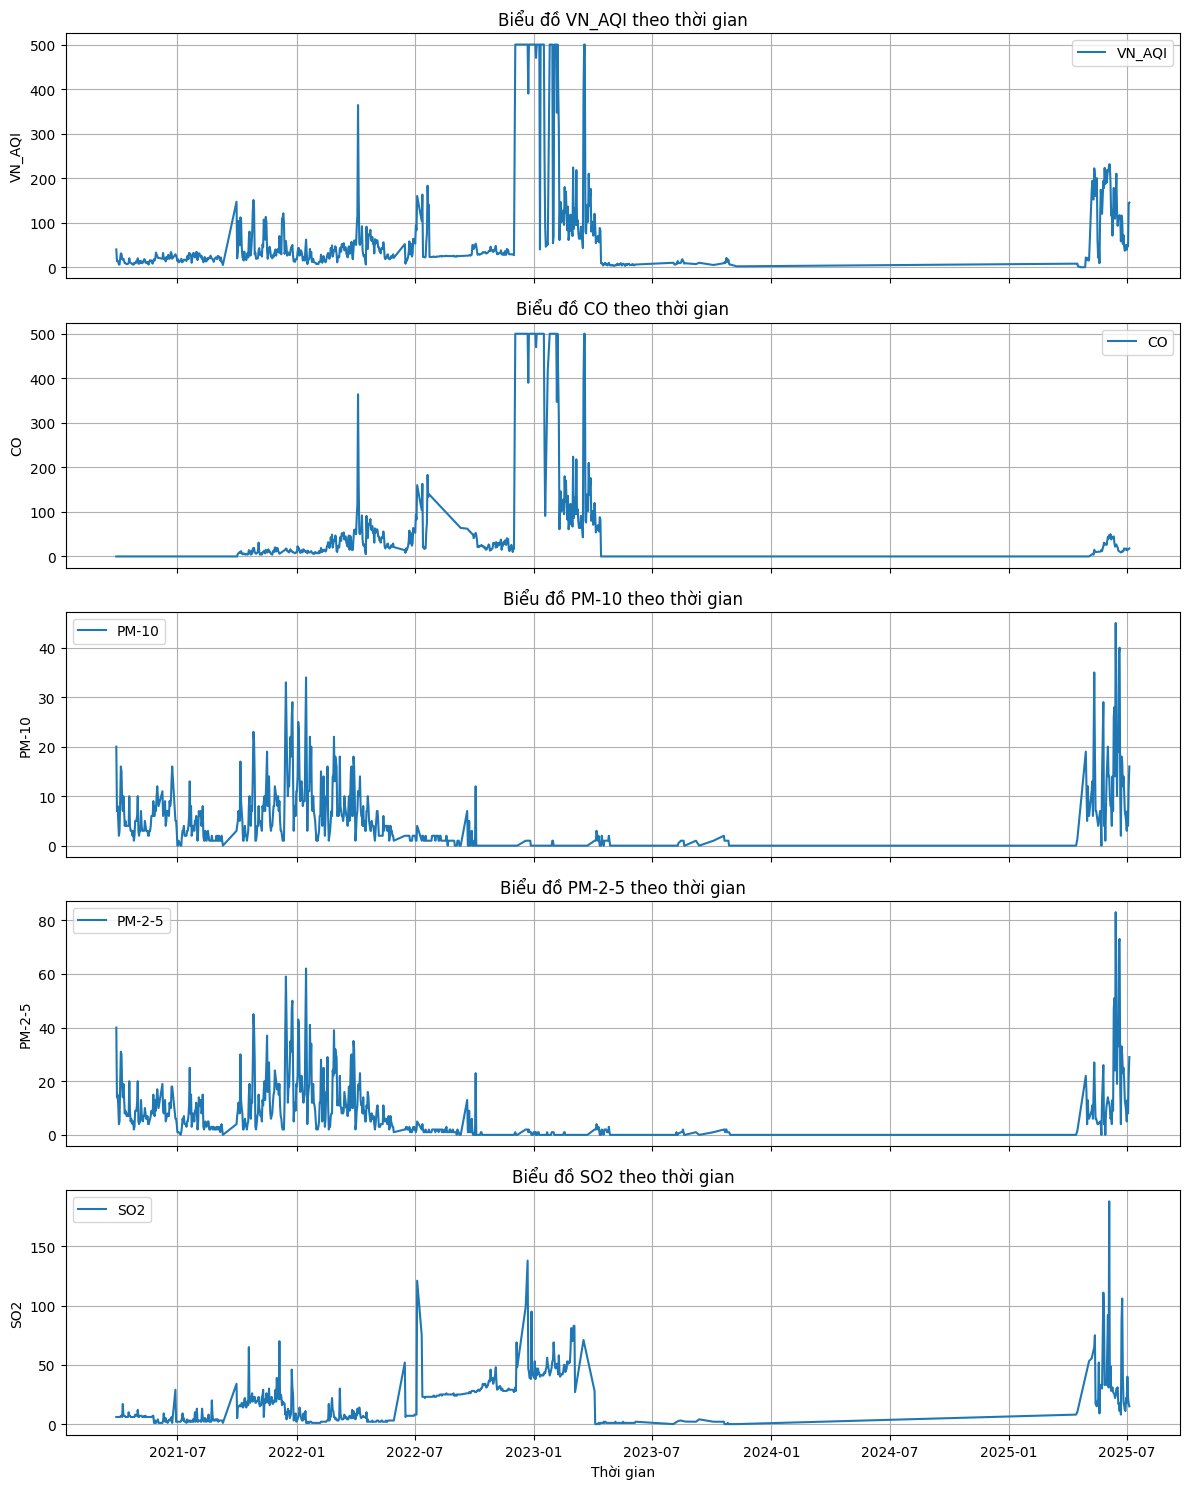

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5   SO2  mon   tu  wed  thu  ...  \
92            5   145.0  18.0   16.0    29.0  15.0  0.0  0.0  0.0  0.0  ...   
93            4   144.0  17.0   12.0    22.0  17.0  0.0  0.0  0.0  0.0  ...   
94            3    47.0  16.0    4.0     8.0  22.0  0.0  0.0  0.0  1.0  ...   
95            2    49.0  14.0    7.0    13.0  40.0  0.0  0.0  1.0  0.0  ...   
96            1    39.0  14.0    3.0     5.0  18.0  0.0  1.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
92     0.0     1.0     0.0  0.0   0.0    1.300984  0.226117   1.619020   
93     0.0     1.0     0.0  0.0   0.0    1.294915  0.198575   1.350474   
94     0.0     1.0     0.0  0.0   0.0    0.318716  0.169459   0.393959   
95     0.0     1.0     0.0  0.0   0.0    0.354762  0.105701   0.864456   
96     0.0     1.0     0.0  0.0   0.0    0.157723  0.105701   0.170581   

    PM-2-5_log   SO2_log  
92    1.658452  0.319780  
93    1.427405  0.420614  

<Figure size 640x480 with 0 Axes>

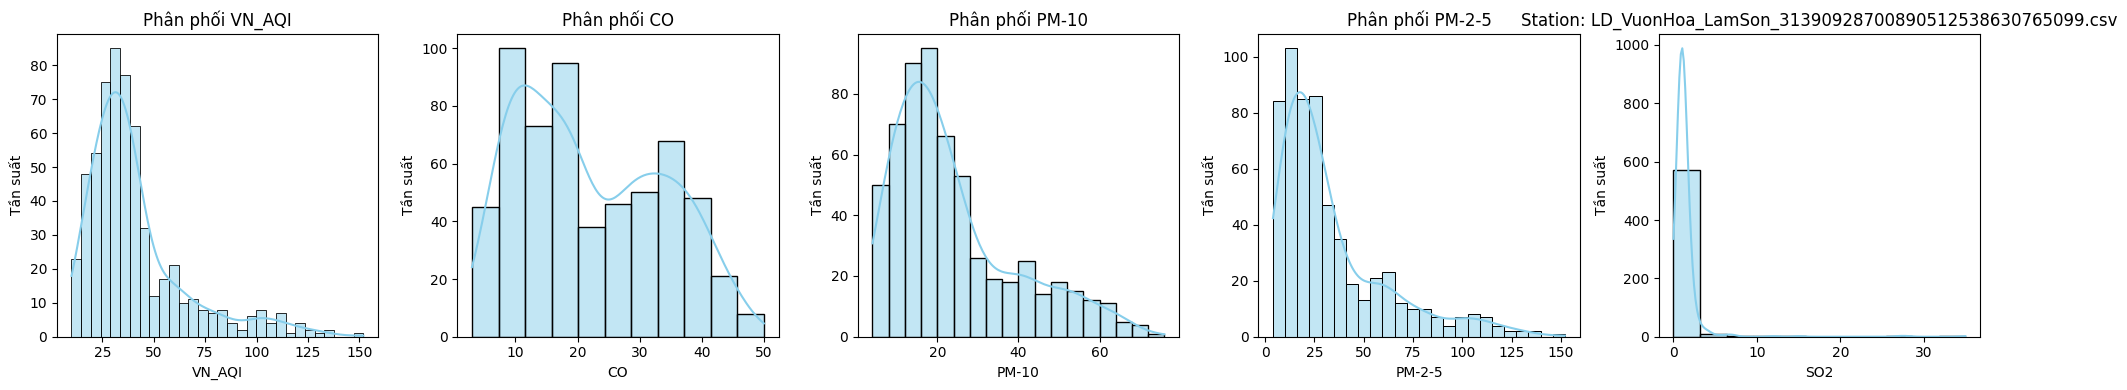

<Figure size 640x480 with 0 Axes>

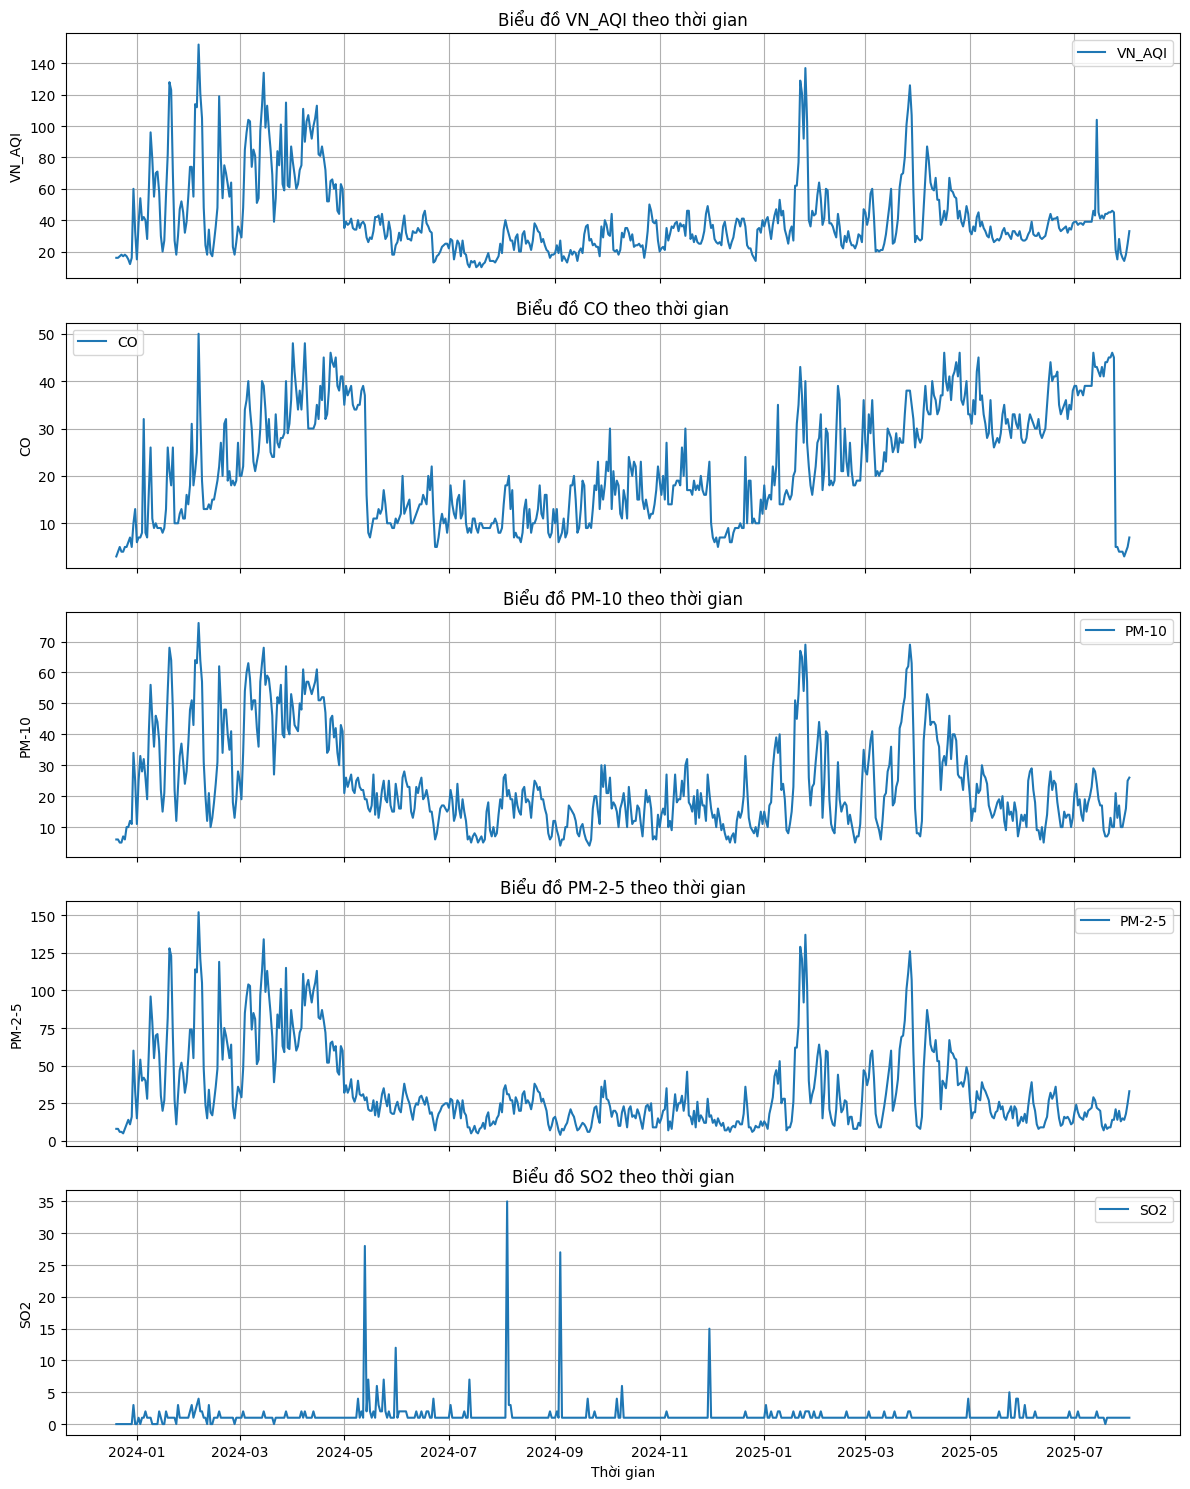

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
65            5    33.0  7.0   26.0    33.0  1.0  0.0  0.0  0.0  0.0  ...   
66            4    25.0  5.0   25.0    25.0  1.0  0.0  0.0  0.0  0.0  ...   
67            3    18.0  4.0   16.0    18.0  1.0  0.0  0.0  0.0  1.0  ...   
68            2    14.0  3.0   13.0    14.0  1.0  0.0  0.0  1.0  0.0  ...   
69            1    16.0  4.0   10.0    15.0  1.0  0.0  1.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
65     0.0     0.0     0.0  1.0   0.0   -0.150583 -1.608704   0.435756   
66     0.0     0.0     0.0  1.0   0.0   -0.683196 -2.116212   0.373009   
67     0.0     0.0     0.0  1.0   0.0   -1.305933 -2.437851  -0.333406   
68     0.0     0.0     0.0  1.0   0.0   -1.775261 -2.831504  -0.656212   
69     0.0     0.0     0.0  1.0   0.0   -1.526762 -2.437851  -1.057170   

    PM-2-5_log   SO2_log  
65    0.348329 -0.195957  
66   -0.021857 -0.195957  
67   -0.454

<Figure size 640x480 with 0 Axes>

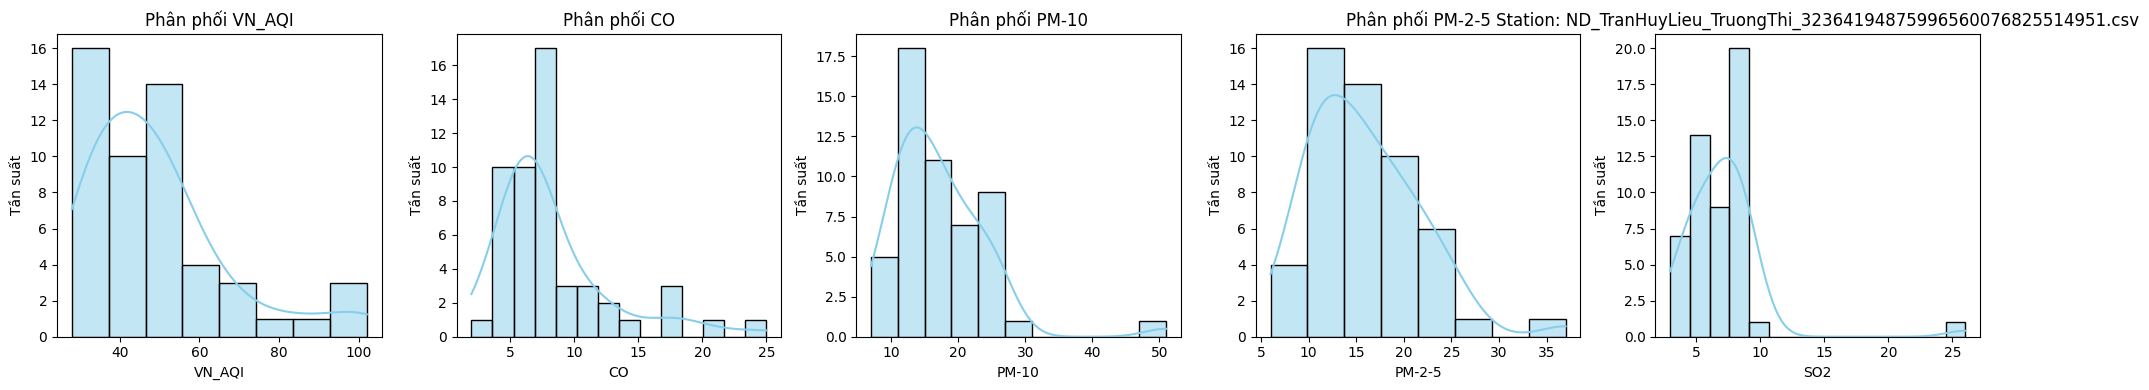

<Figure size 640x480 with 0 Axes>

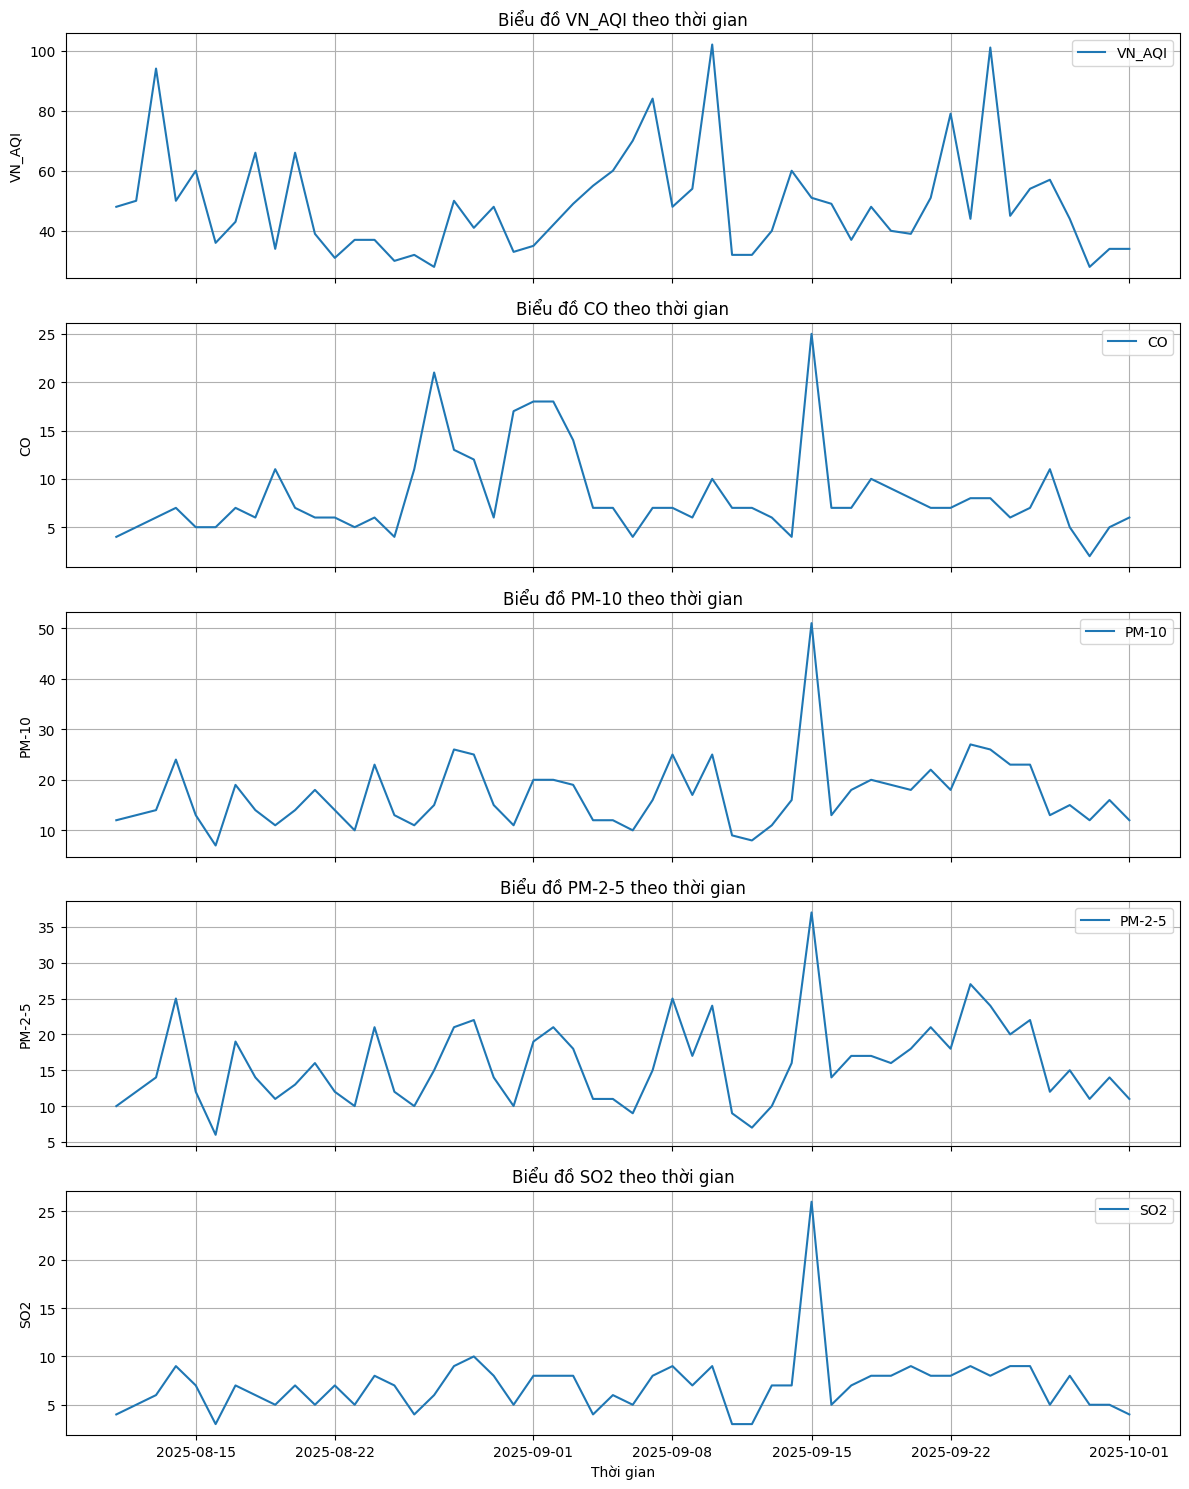

   Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
5            2    34.0   6.0   12.0    11.0  4.0  0.0  0.0  1.0  0.0  ...   
6            1    34.0   5.0   16.0    14.0  5.0  0.0  1.0  0.0  0.0  ...   
7            0    28.0   2.0   12.0    11.0  5.0  1.0  0.0  0.0  0.0  ...   
8            6    44.0   5.0   15.0    15.0  8.0  0.0  0.0  0.0  0.0  ...   
9            5    57.0  11.0   13.0    12.0  5.0  0.0  0.0  0.0  0.0  ...   

   summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
5     0.0     0.0     1.0  0.0   0.0   -0.981291 -0.464577  -0.784161   
6     0.0     1.0     0.0  0.0   0.0   -0.981291 -0.842411   0.000898   
7     0.0     1.0     0.0  0.0   0.0   -1.584497 -2.541365  -0.784161   
8     0.0     1.0     0.0  0.0   0.0   -0.175163 -0.842411  -0.176517   
9     0.0     1.0     0.0  0.0   0.0    0.638876  0.856543  -0.567288   

   PM-2-5_log   SO2_log  
5   -0.842838 -1.321348  
6   -0.179805 -0.746784  
7   -0.842838 -0.746

<Figure size 640x480 with 0 Axes>

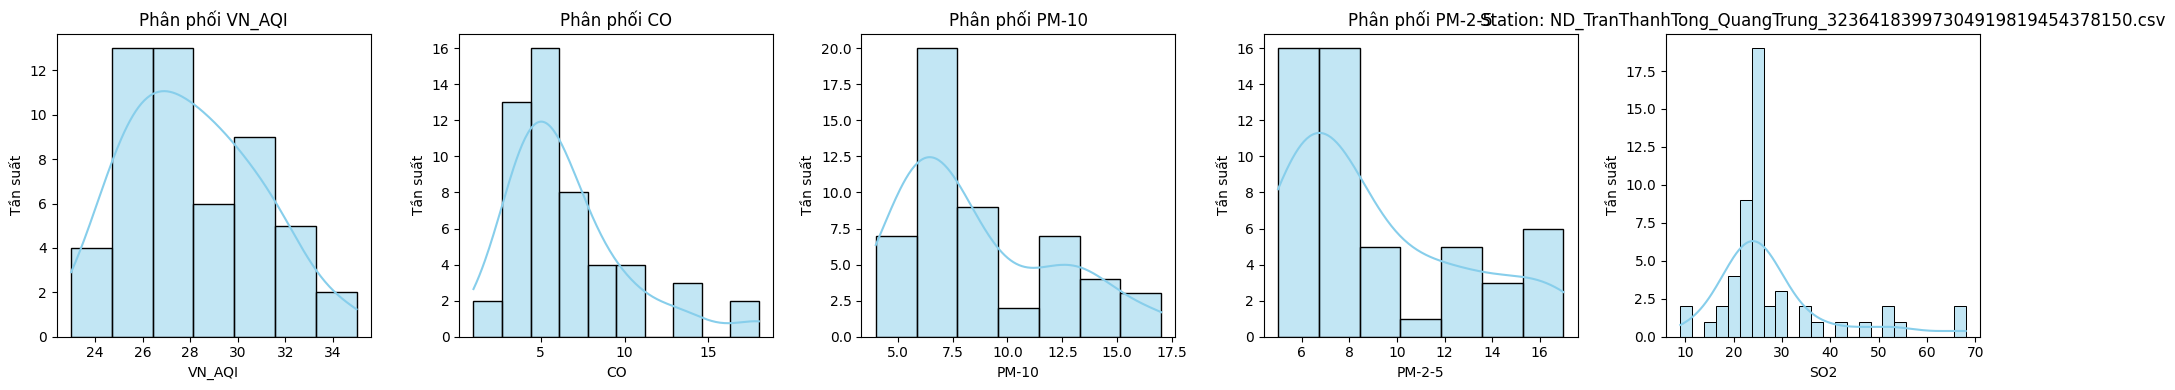

<Figure size 640x480 with 0 Axes>

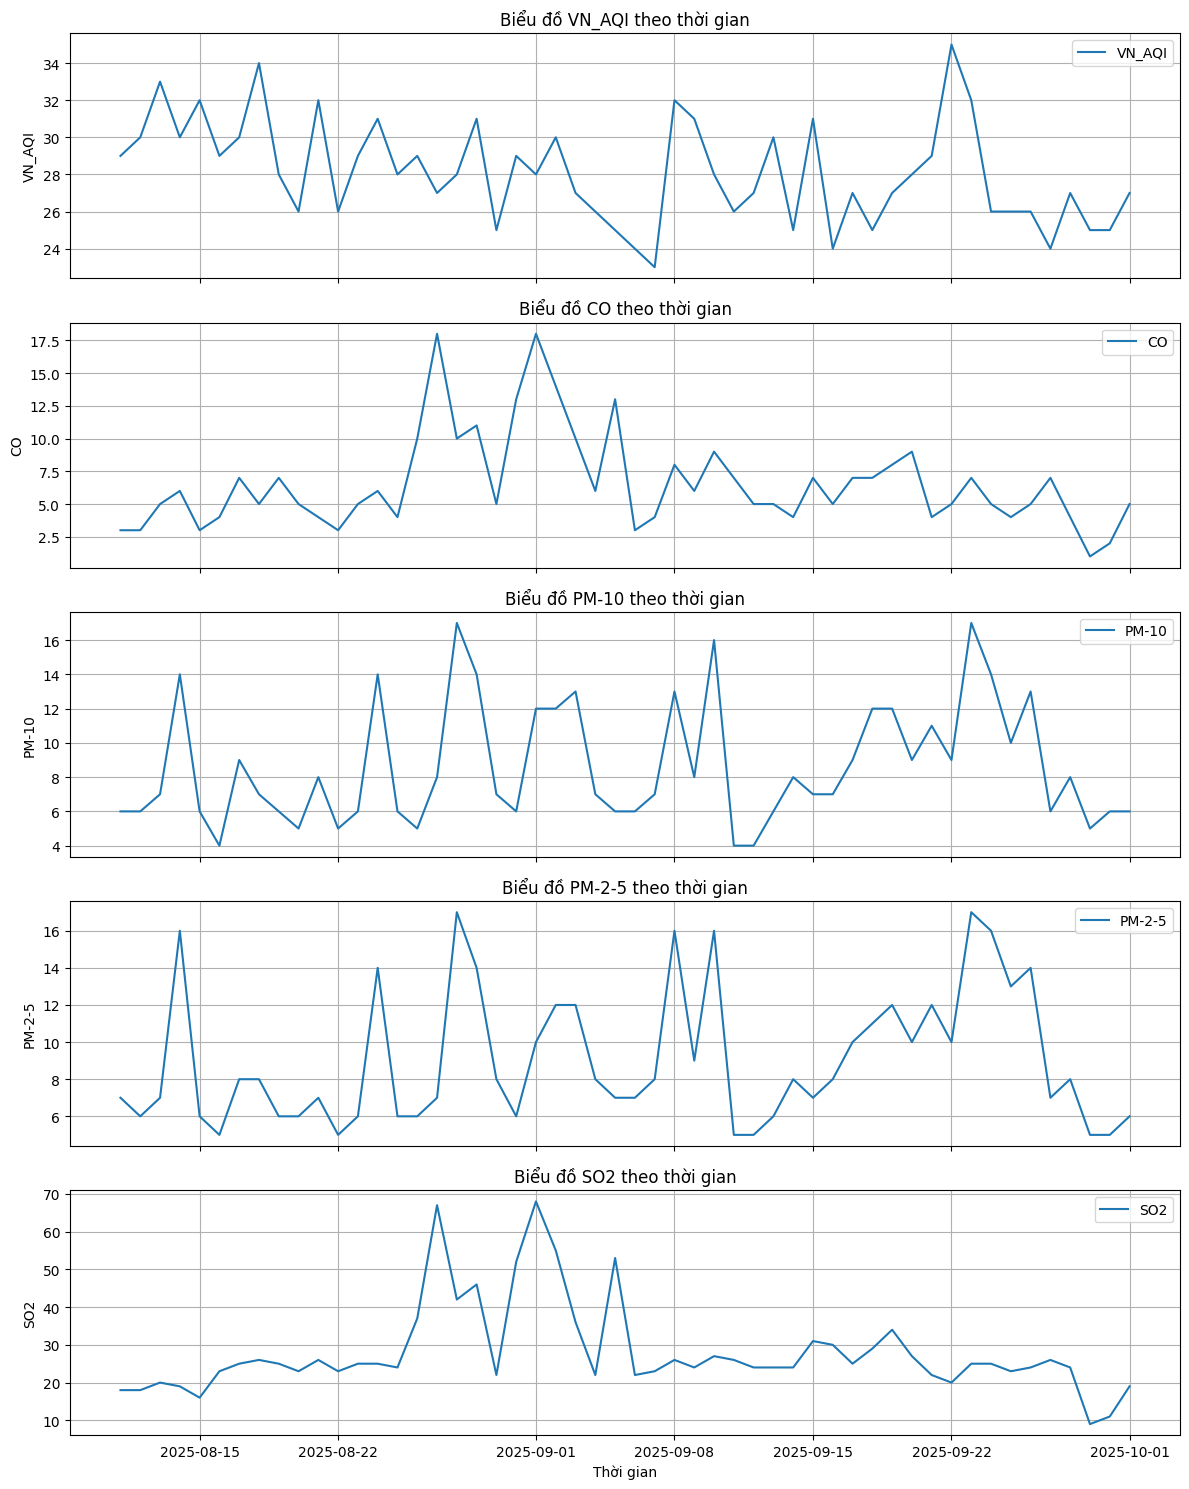

   Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5   SO2  mon   tu  wed  thu  ...  \
5            2    27.0  5.0    6.0     6.0  19.0  0.0  0.0  1.0  0.0  ...   
6            1    25.0  2.0    6.0     5.0  11.0  0.0  1.0  0.0  0.0  ...   
7            0    25.0  1.0    5.0     5.0   9.0  1.0  0.0  0.0  0.0  ...   
8            6    27.0  4.0    8.0     8.0  24.0  0.0  0.0  0.0  0.0  ...   
9            5    24.0  7.0    6.0     7.0  26.0  0.0  0.0  0.0  0.0  ...   

   summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
5     0.0     0.0     1.0  0.0   0.0   -0.368082 -0.302880  -0.737515   
6     0.0     1.0     0.0  0.0   0.0   -1.156103 -1.884860  -0.737515   
7     0.0     1.0     0.0  0.0   0.0   -1.156103 -2.810260  -1.179904   
8     0.0     1.0     0.0  0.0   0.0   -0.368082 -0.718995  -0.016280   
9     0.0     1.0     0.0  0.0   0.0   -1.573153  0.353701  -0.737515   

   PM-2-5_log   SO2_log  
5   -0.895991 -0.850586  
6   -1.351959 -2.273293  
7   -1.351959 -2.781

<Figure size 640x480 with 0 Axes>

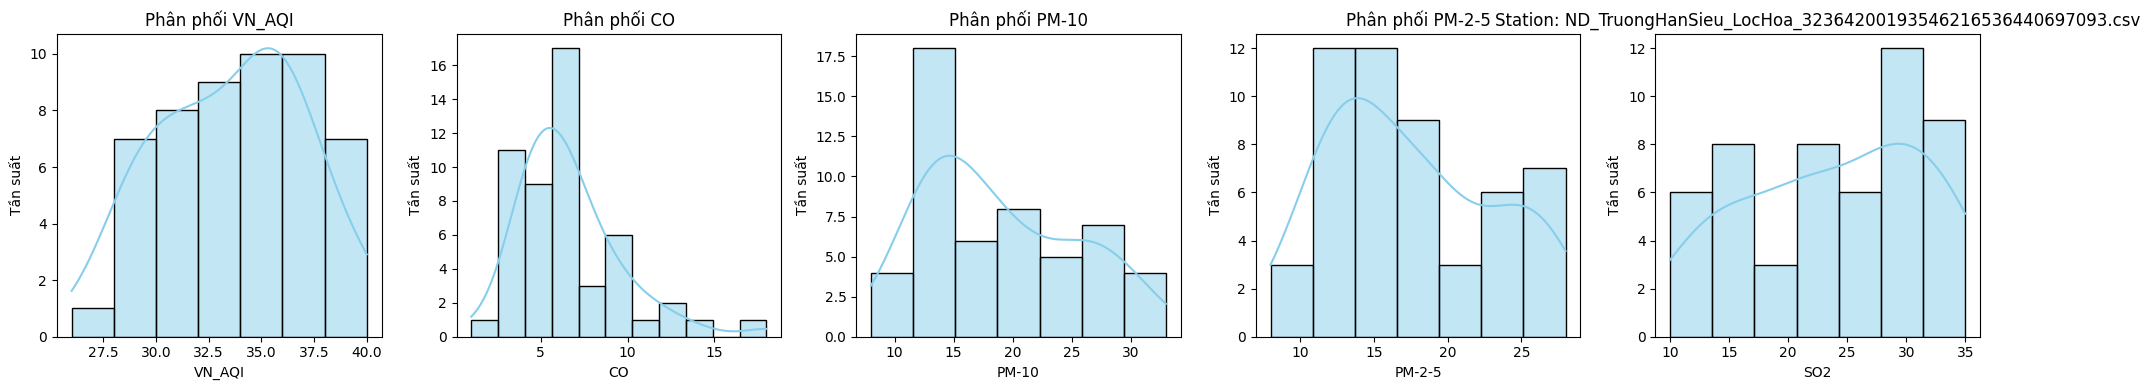

<Figure size 640x480 with 0 Axes>

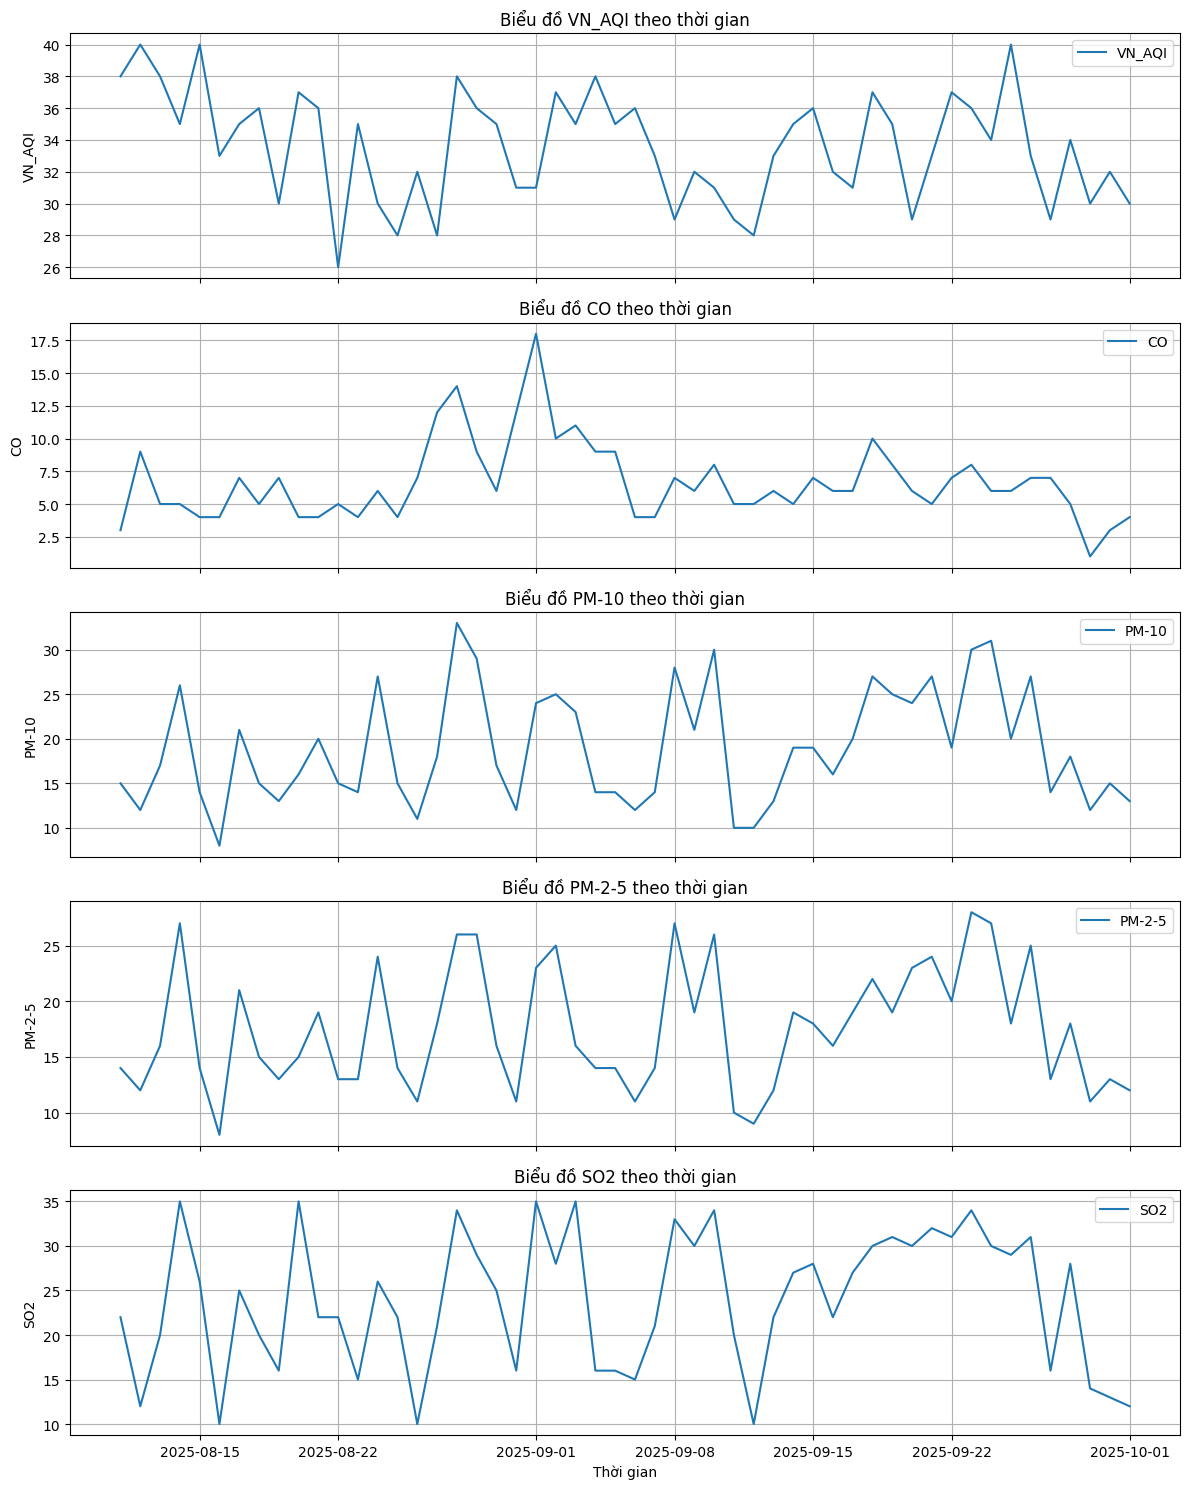

   Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5   SO2  mon   tu  wed  thu  ...  \
5            2    30.0  4.0   13.0    12.0  12.0  0.0  0.0  1.0  0.0  ...   
6            1    32.0  3.0   15.0    13.0  13.0  0.0  1.0  0.0  0.0  ...   
7            0    30.0  1.0   12.0    11.0  14.0  1.0  0.0  0.0  0.0  ...   
8            6    34.0  5.0   18.0    18.0  28.0  0.0  0.0  0.0  0.0  ...   
9            5    29.0  7.0   14.0    13.0  16.0  0.0  0.0  0.0  0.0  ...   

   summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
5     0.0     0.0     1.0  0.0   0.0   -1.029837 -0.944551  -0.926868   
6     0.0     1.0     0.0  0.0   0.0   -0.414562 -1.540220  -0.513235   
7     0.0     1.0     0.0  0.0   0.0   -1.029837 -3.390539  -1.156428   
8     0.0     1.0     0.0  0.0   0.0    0.164499 -0.457853   0.019097   
9     0.0     1.0     0.0  0.0   0.0   -1.352528  0.310098  -0.713152   

   PM-2-5_log   SO2_log  
5   -1.023817 -1.726163  
6   -0.778233 -1.511347  
7   -1.289068 -1.311

<Figure size 640x480 with 0 Axes>

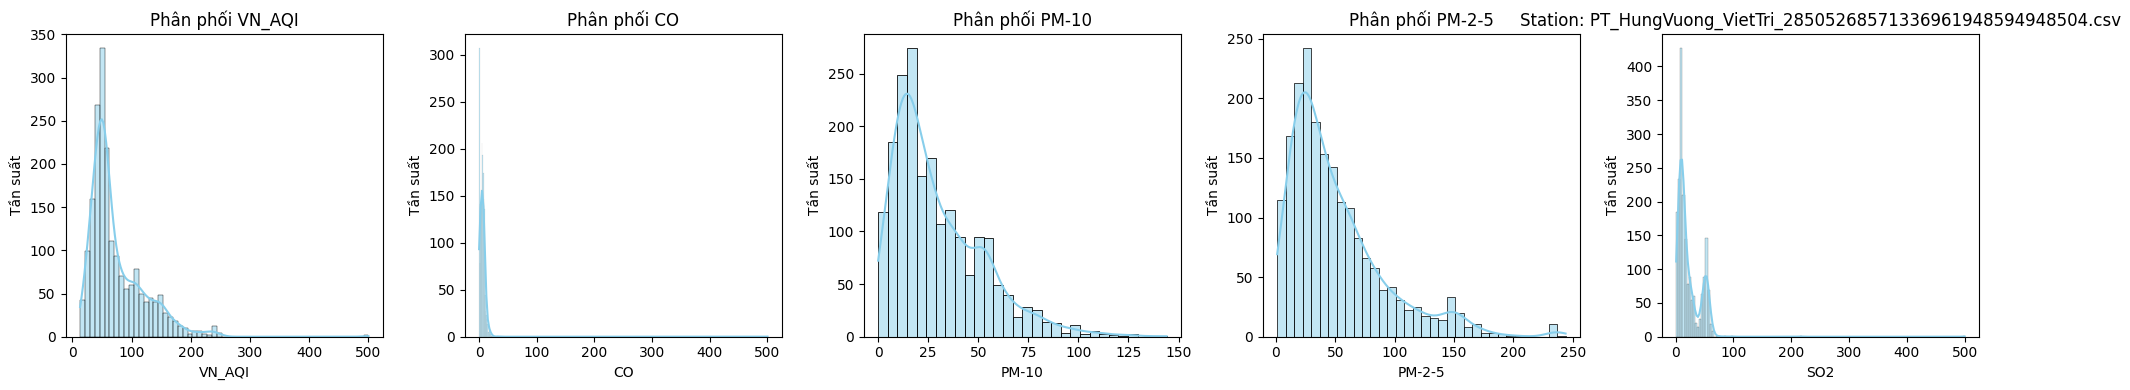

<Figure size 640x480 with 0 Axes>

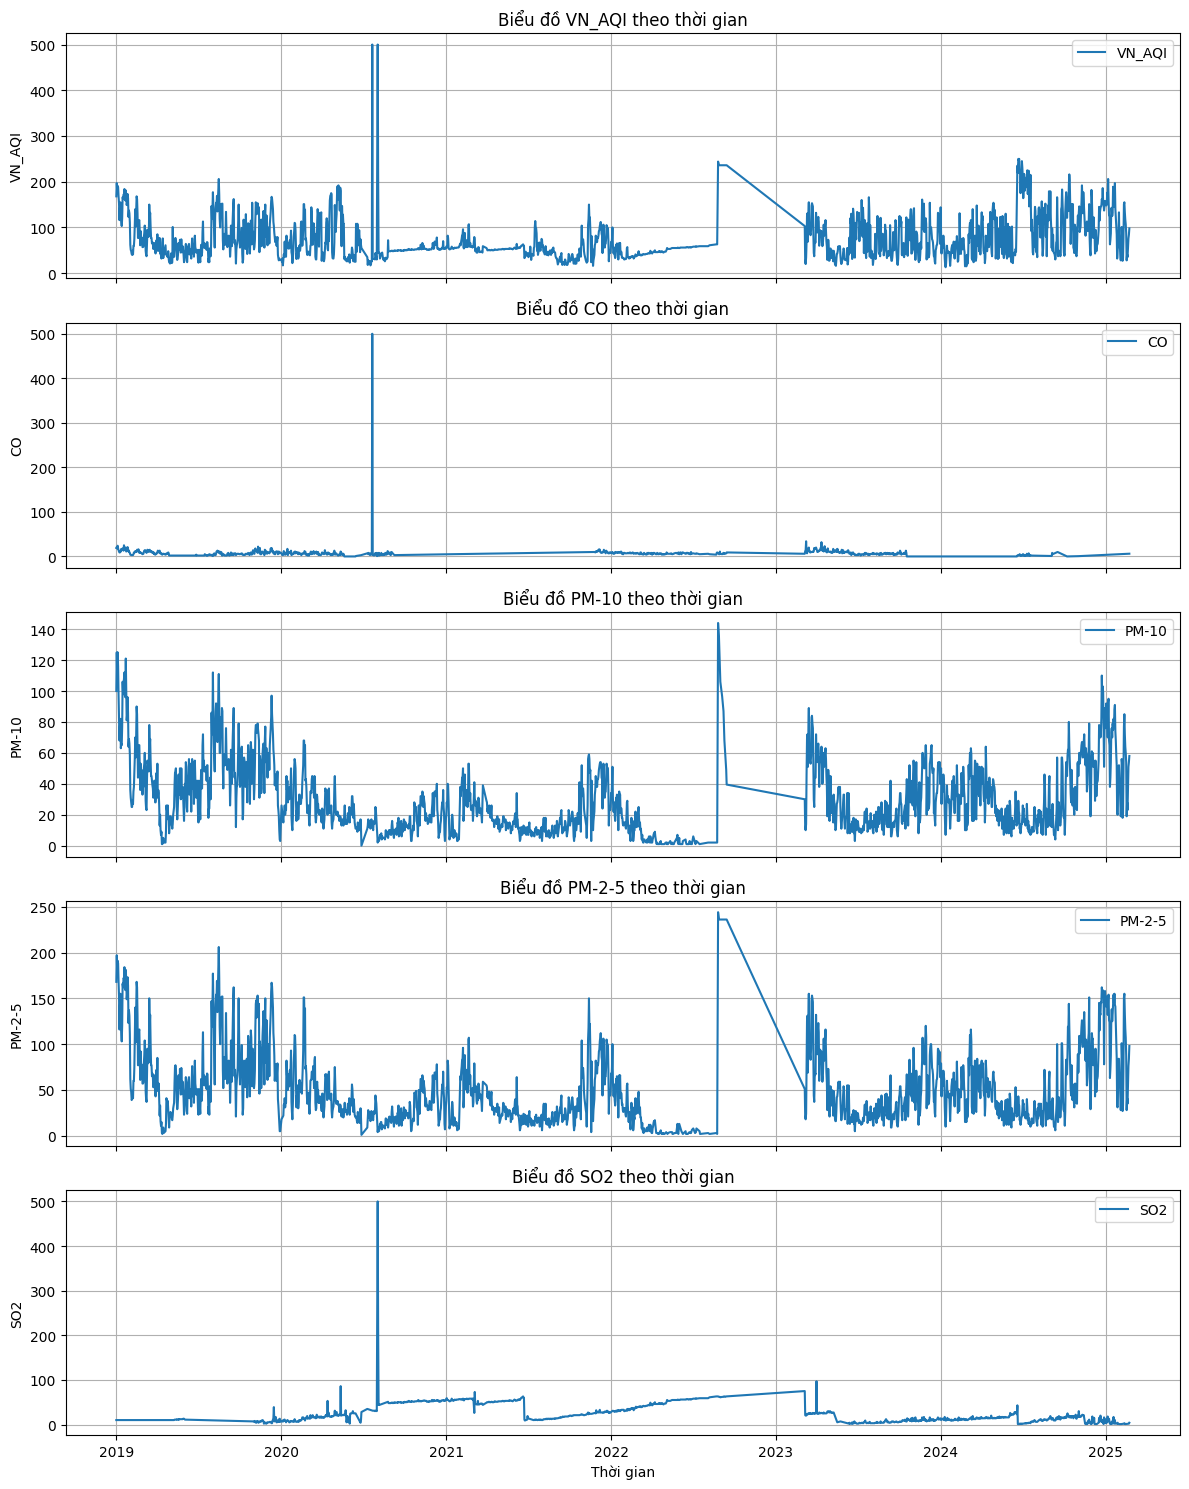

     Day_Of_Week  VN_AQI        CO  PM-10  PM-2-5       SO2  mon   tu  wed  \
215            5    98.0  6.123188   58.0    98.0  4.000000  0.0  0.0  0.0   
216            4    84.0  6.072464   54.0    84.0  2.000000  0.0  0.0  0.0   
217            3    76.0  6.021739   51.0    76.0  1.857143  0.0  0.0  0.0   
218            2    56.0  5.971014   38.0    56.0  1.714286  0.0  0.0  1.0   
219            1    35.0  5.920290   23.0    35.0  1.571429  0.0  1.0  0.0   

     thu  ...  summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  \
215  0.0  ...     0.0     0.0     0.0  0.0   0.0    0.792303  0.422750   
216  0.0  ...     0.0     0.0     0.0  0.0   0.0    0.513457  0.414086   
217  1.0  ...     0.0     0.0     0.0  0.0   0.0    0.332681  0.405360   
218  0.0  ...     0.0     0.0     0.0  0.0   0.0   -0.217360  0.396571   
219  0.0  ...     0.0     0.0     0.0  0.0   0.0   -1.057786  0.387718   

     PM-10_log  PM-2-5_log   SO2_log  
215   1.125464    1.133429 -1.414920  
216   1.

<Figure size 640x480 with 0 Axes>

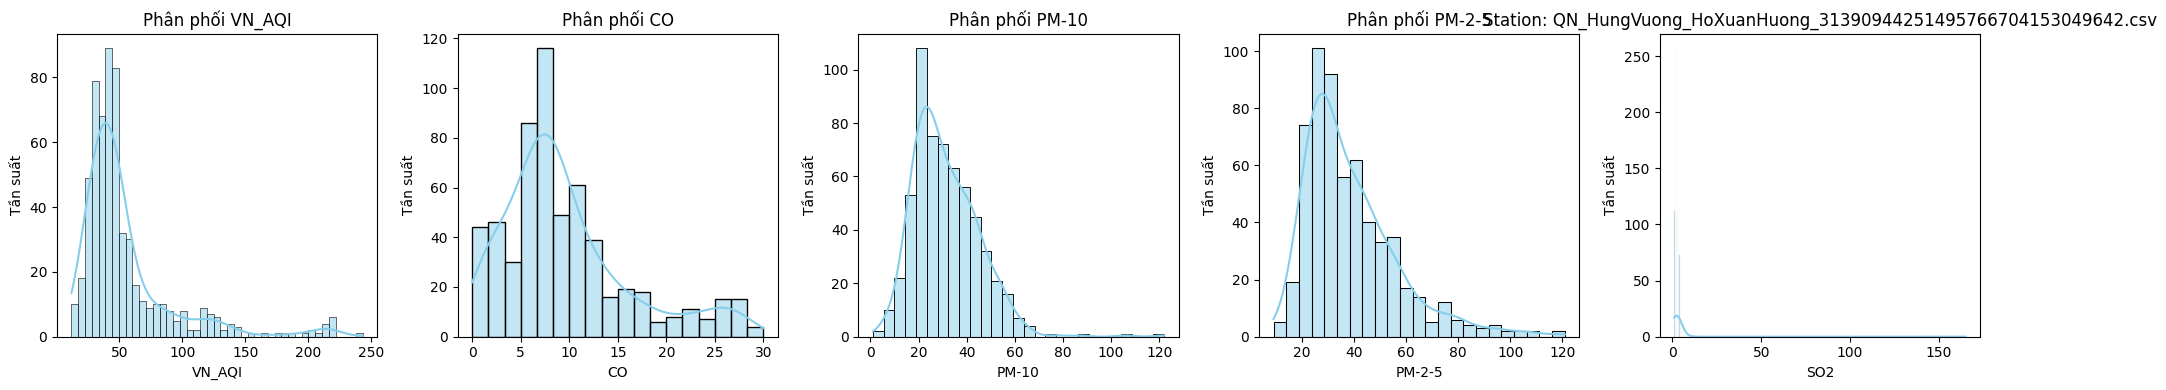

<Figure size 640x480 with 0 Axes>

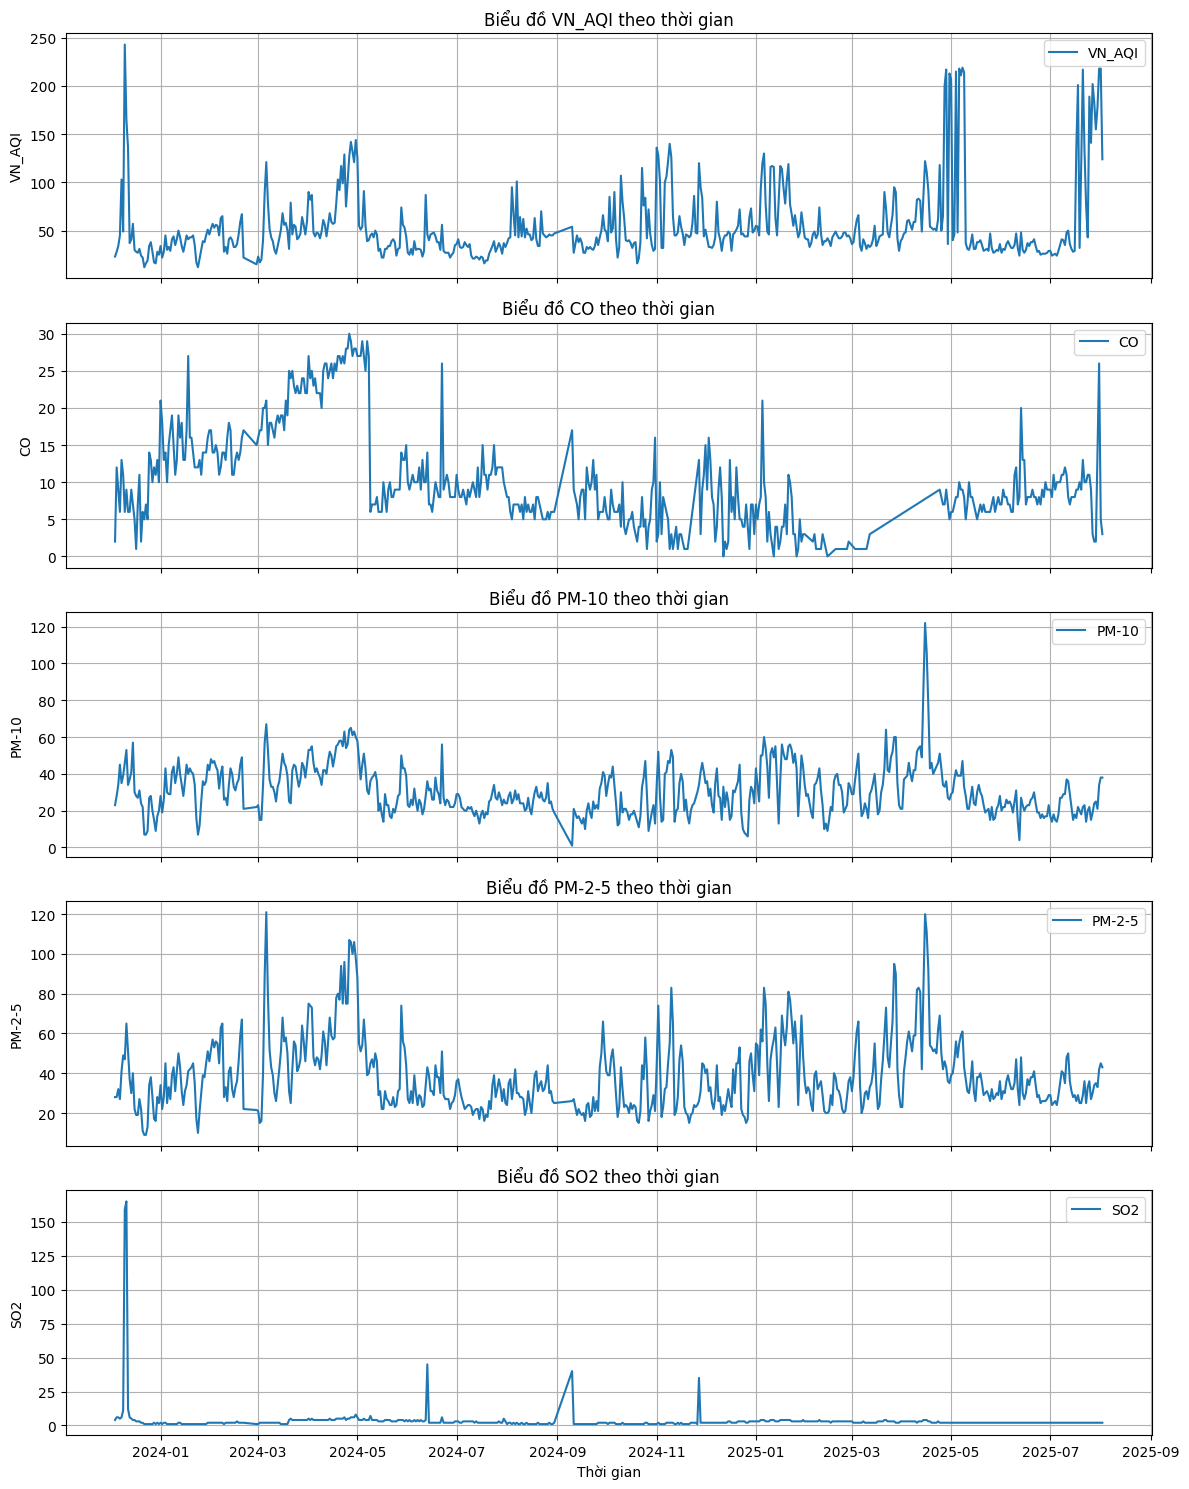

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
65            5   124.0   3.0   38.0    43.0  2.0  0.0  0.0  0.0  0.0  ...   
66            4   218.0   5.0   38.0    45.0  2.0  0.0  0.0  0.0  0.0  ...   
67            3   218.0  26.0   34.0    42.0  2.0  0.0  0.0  0.0  1.0  ...   
68            2   178.0  14.0   21.0    33.0  2.0  0.0  0.0  1.0  0.0  ...   
69            1   155.0   2.0   25.0    35.0  2.0  0.0  1.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
65     0.0     0.0     0.0  1.0   0.0    1.884330 -1.125344   0.632646   
66     0.0     0.0     0.0  1.0   0.0    2.977639 -0.529324   0.632646   
67     0.0     0.0     0.0  1.0   0.0    2.977639  1.681619   0.386208   
68     0.0     0.0     0.0  1.0   0.0    2.584413  0.817592  -0.671167   
69     0.0     0.0     0.0  1.0   0.0    2.316271 -1.548227  -0.290731   

    PM-2-5_log   SO2_log  
65    0.462894 -0.249118  
66    0.570059 -0.249118  
67   

<Figure size 640x480 with 0 Axes>

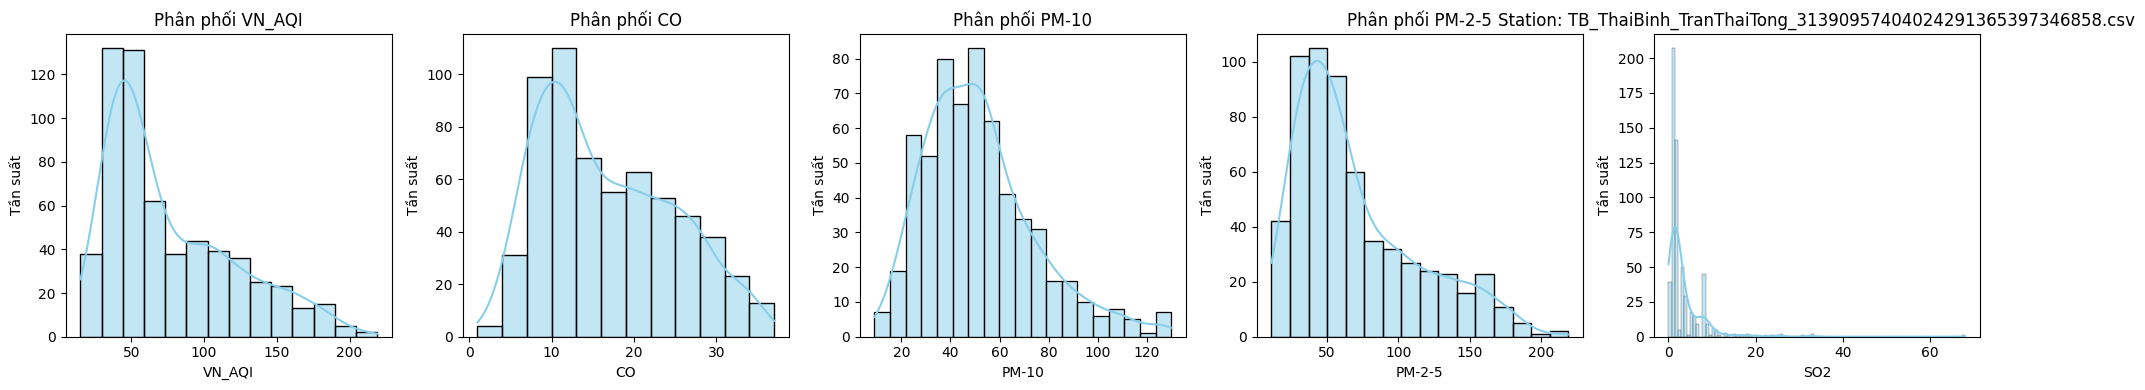

<Figure size 640x480 with 0 Axes>

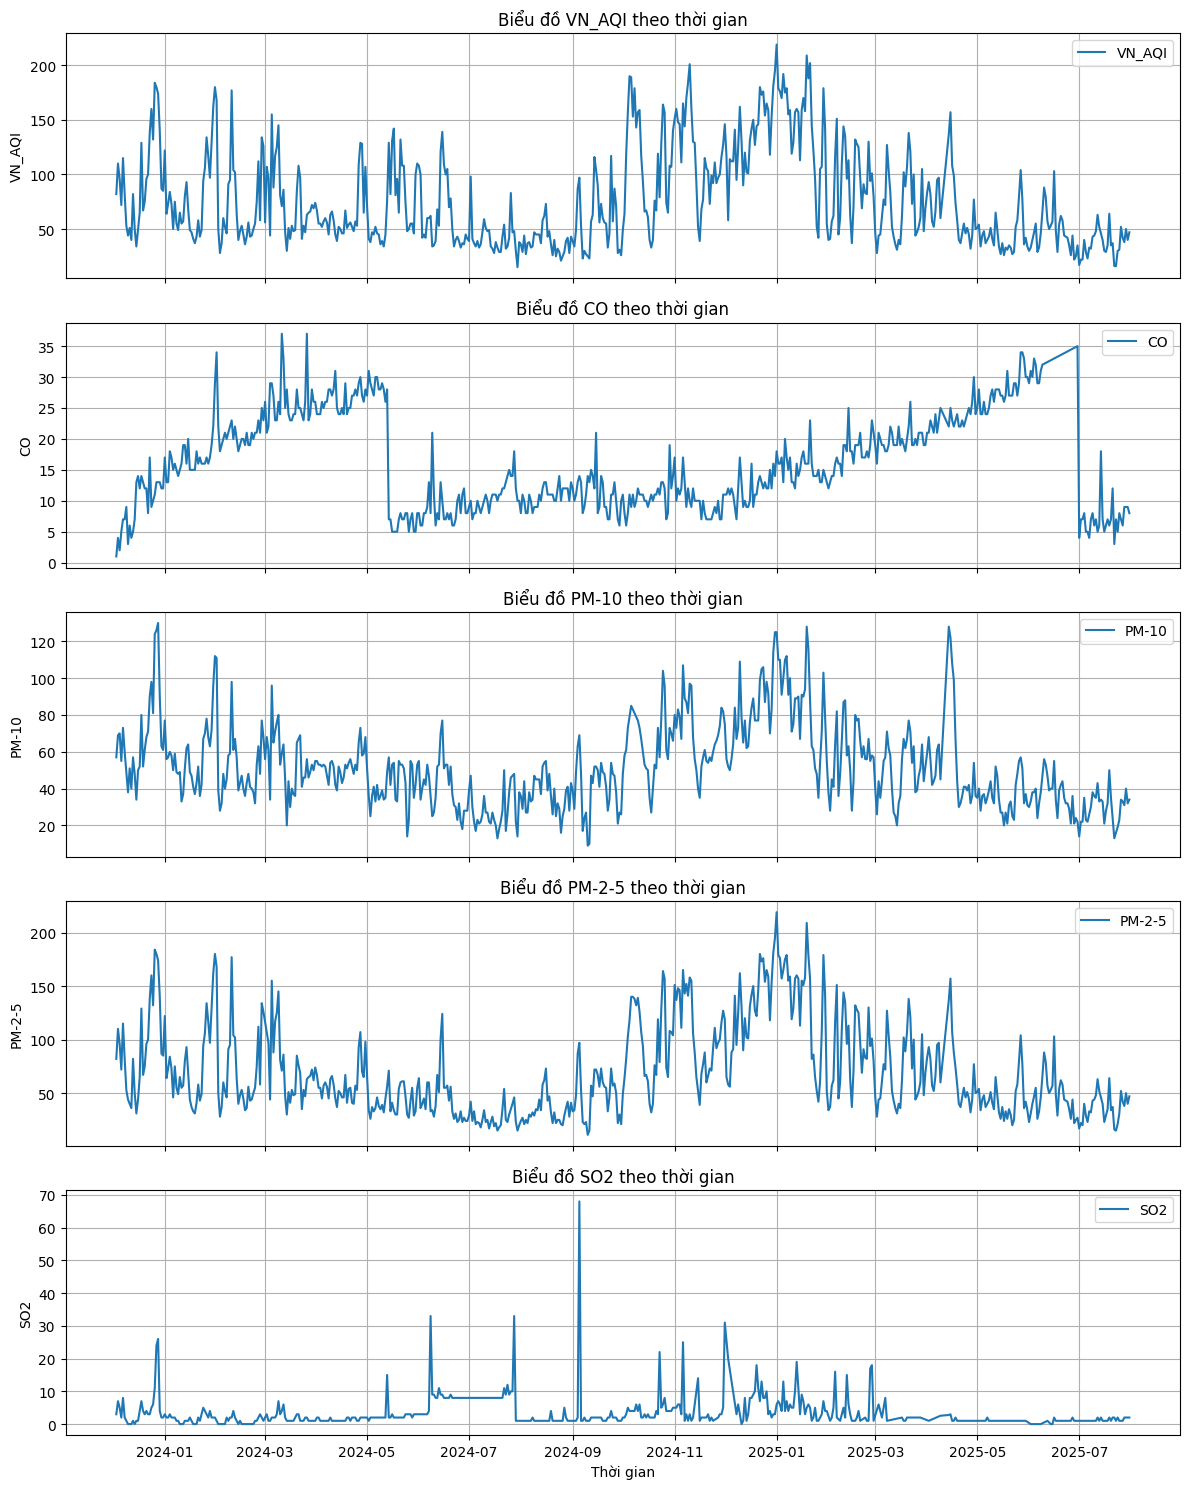

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
67            3    47.0  8.0   34.0    47.0  2.0  0.0  0.0  0.0  1.0  ...   
68            2    40.0  9.0   32.0    40.0  2.0  0.0  0.0  1.0  0.0  ...   
69            1    50.0  9.0   40.0    50.0  2.0  0.0  1.0  0.0  0.0  ...   
70            0    38.0  9.0   31.0    38.0  2.0  1.0  0.0  0.0  0.0  ...   
71            6    42.0  6.0   33.0    42.0  1.0  0.0  0.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
67     0.0     1.0     0.0  0.0   0.0   -0.588358 -1.125946  -0.738374   
68     0.0     1.0     0.0  0.0   0.0   -0.874145 -0.912282  -0.873892   
69     0.0     1.0     0.0  0.0   0.0   -0.478443 -0.912282  -0.373960   
70     0.0     1.0     0.0  0.0   0.0   -0.964816 -0.912282  -0.944764   
71     0.0     1.0     0.0  0.0   0.0   -0.787793 -1.635594  -0.805136   

    PM-2-5_log   SO2_log  
67   -0.370635 -0.143508  
68   -0.637885 -0.143508  
69   -0.267

<Figure size 640x480 with 0 Axes>

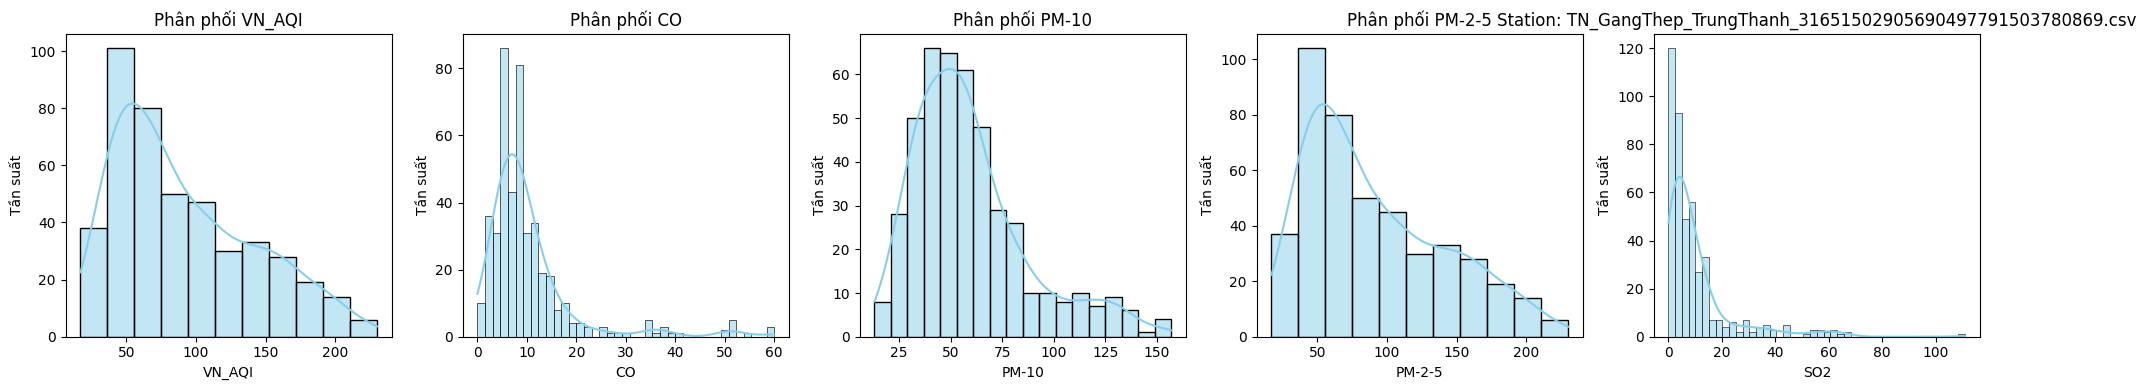

<Figure size 640x480 with 0 Axes>

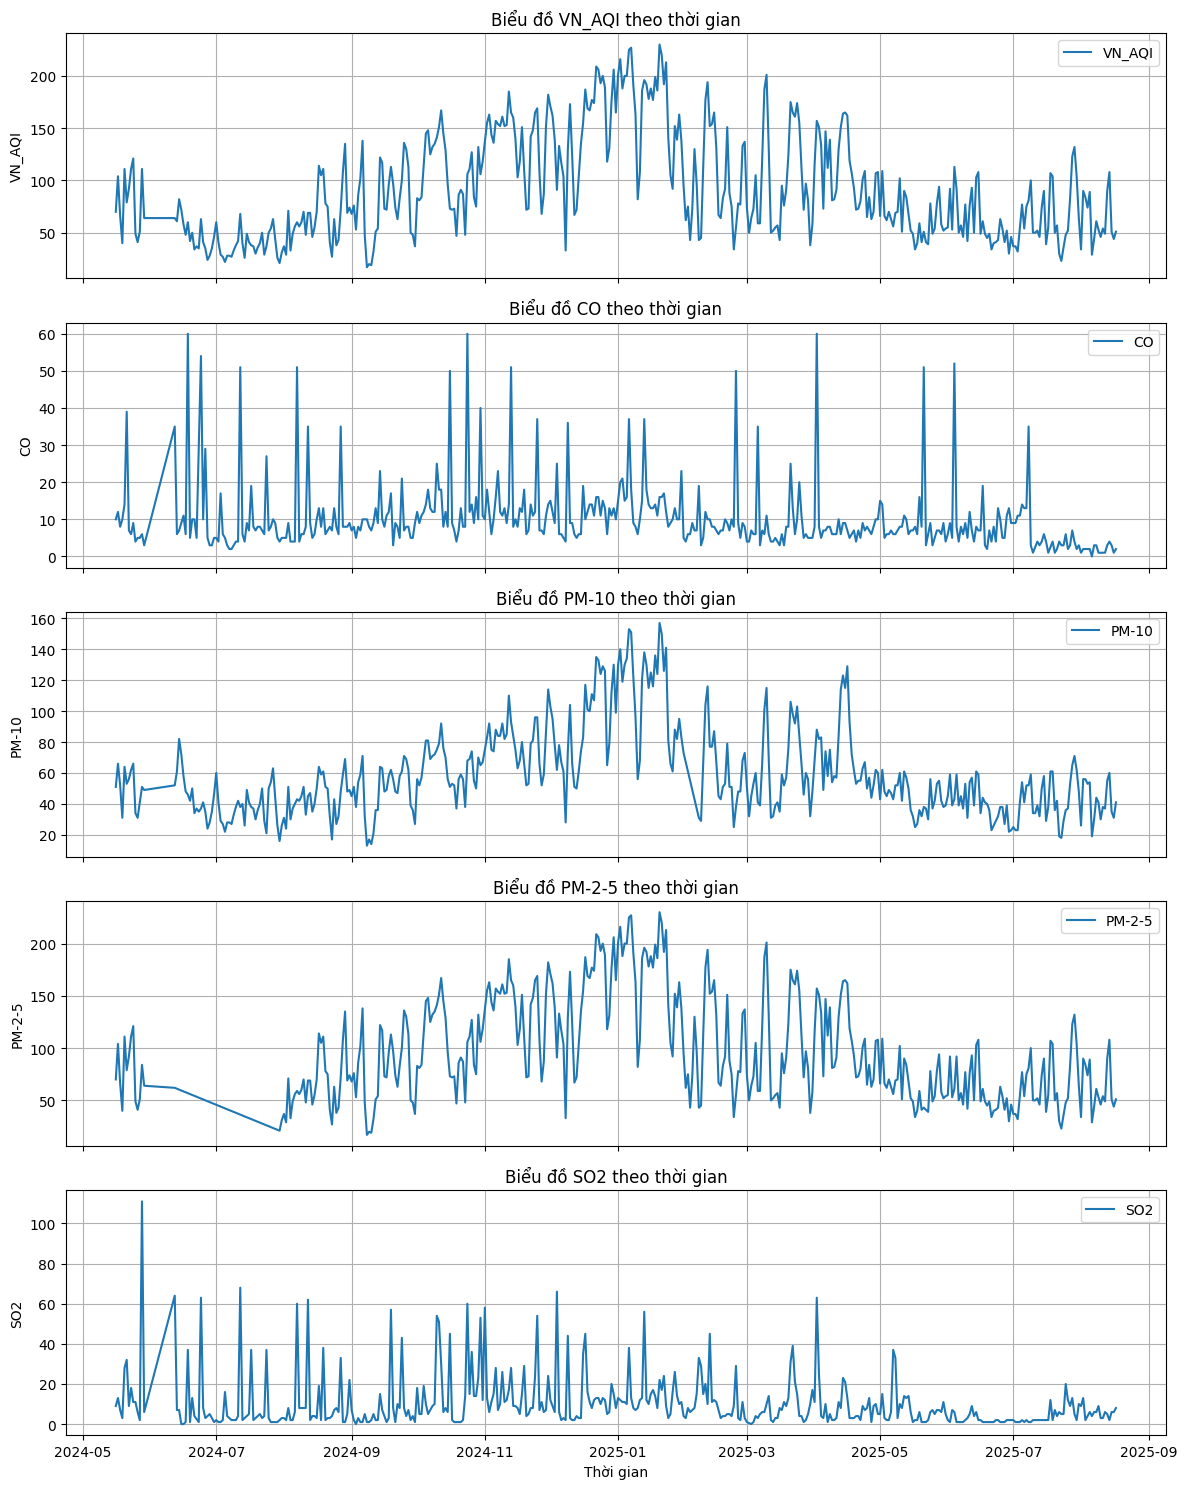

    Day_Of_Week  VN_AQI   CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
49            6    51.0  2.0   41.0    51.0  8.0  0.0  0.0  0.0  0.0  ...   
50            5    44.0  1.0   31.0    44.0  6.0  0.0  0.0  0.0  0.0  ...   
51            4    51.0  3.0   35.0    51.0  6.0  0.0  0.0  0.0  0.0  ...   
52            3   108.0  4.0   60.0   108.0  2.0  0.0  0.0  0.0  1.0  ...   
53            2    90.0  3.0   55.0    90.0  5.0  0.0  0.0  1.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
49     0.0     1.0     0.0  0.0   0.0   -0.774307 -1.781613  -0.581925   
50     0.0     1.0     0.0  0.0   0.0   -1.034269 -2.433358  -1.189476   
51     0.0     1.0     0.0  0.0   0.0   -0.774307 -1.319192  -0.926327   
52     0.0     1.0     0.0  0.0   0.0    0.556426 -0.960511   0.251884   
53     0.0     1.0     0.0  0.0   0.0    0.231901 -1.319192   0.060812   

    PM-2-5_log   SO2_log  
49   -0.768229  0.261288  
50   -1.028176 -0.012906  
51   -0.768

<Figure size 640x480 with 0 Axes>

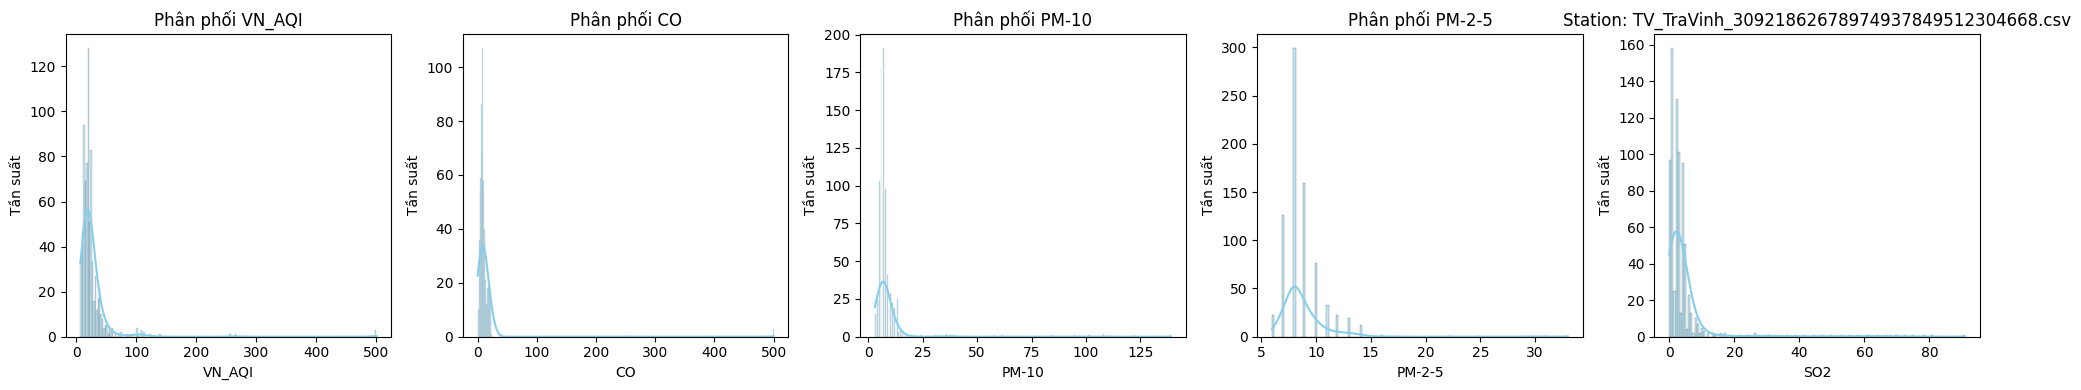

<Figure size 640x480 with 0 Axes>

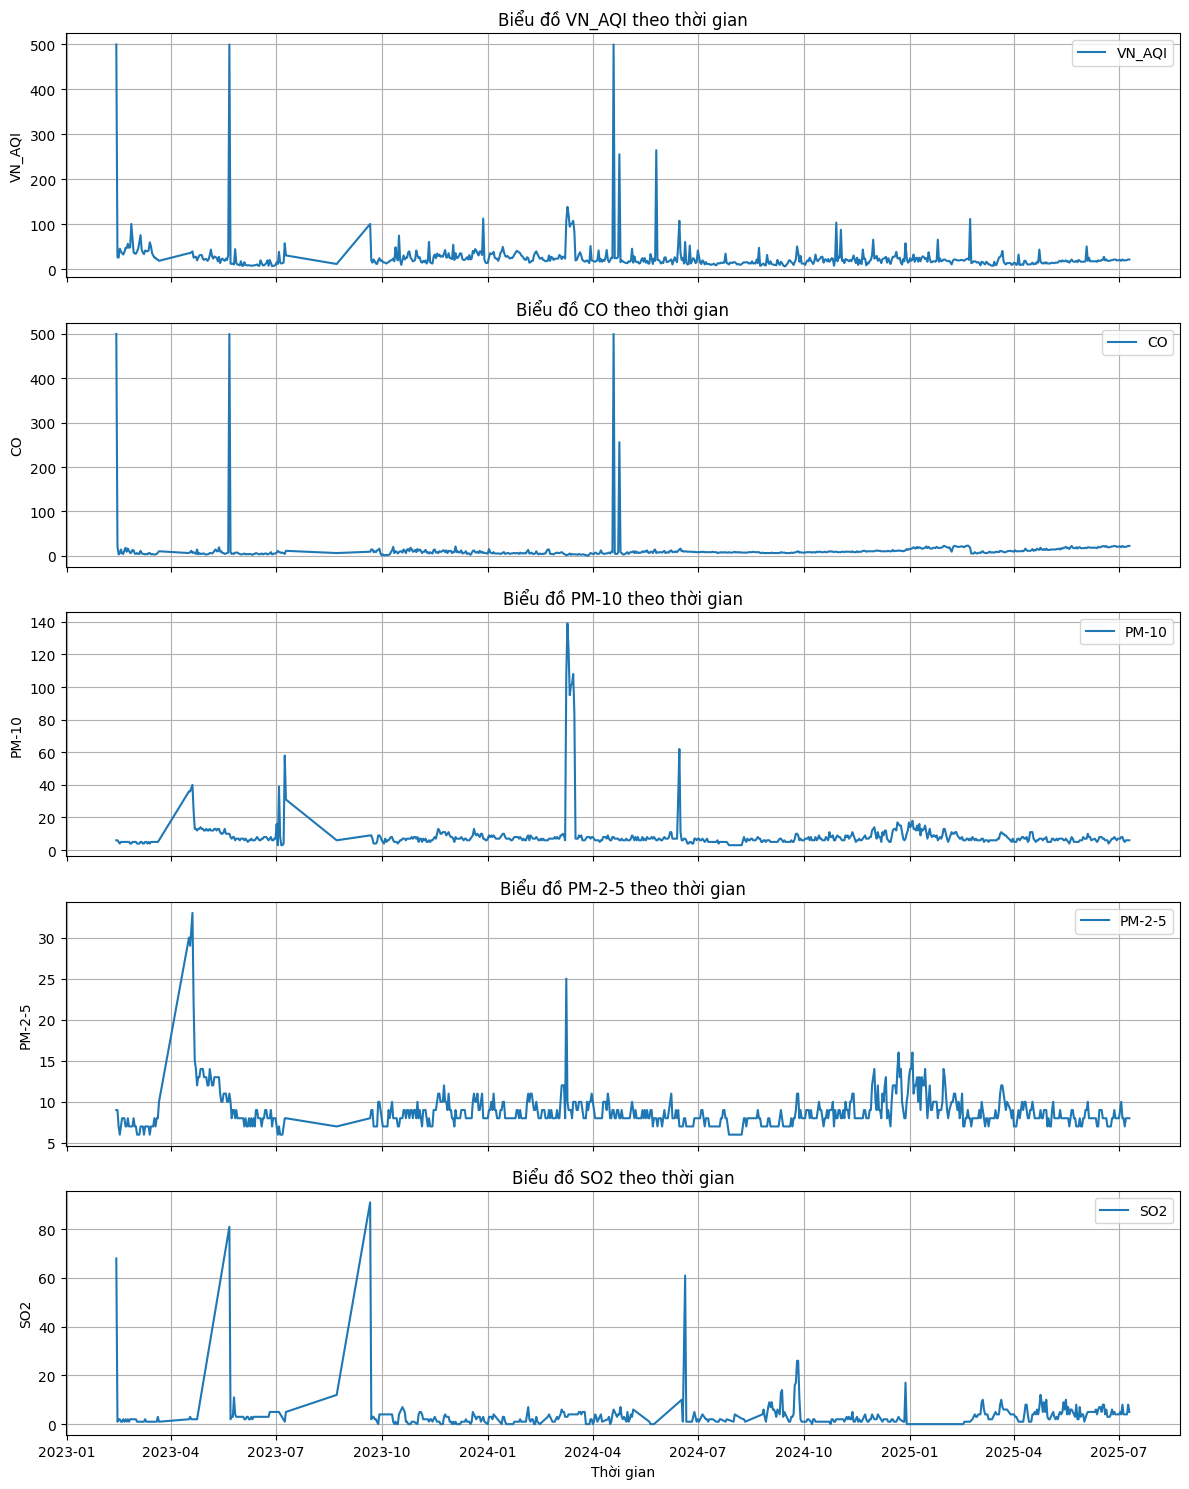

    Day_Of_Week  VN_AQI    CO  PM-10  PM-2-5  SO2  mon   tu  wed  thu  ...  \
86            3    22.0  22.0    6.0     8.0  5.0  0.0  0.0  0.0  1.0  ...   
87            2    22.0  22.0    6.0     8.0  8.0  0.0  0.0  1.0  0.0  ...   
88            1    21.0  21.0    6.0     8.0  4.0  0.0  1.0  0.0  0.0  ...   
89            0    20.0  20.0    6.0     8.0  4.0  1.0  0.0  0.0  0.0  ...   
90            6    20.0  20.0    5.0     7.0  4.0  0.0  0.0  0.0  0.0  ...   

    summer  autumn  winter  dry  rain  VN_AQI_log    CO_log  PM-10_log  \
86     0.0     0.0     0.0  1.0   0.0    0.071290  1.586994  -0.428696   
87     0.0     0.0     0.0  1.0   0.0    0.071290  1.586994  -0.428696   
88     0.0     0.0     0.0  1.0   0.0   -0.013972  1.508033  -0.428696   
89     0.0     0.0     0.0  1.0   0.0   -0.103202  1.425397  -0.428696   
90     0.0     0.0     0.0  1.0   0.0   -0.103202  1.425397  -0.802044   

    PM-2-5_log   SO2_log  
86   -0.367130  0.681068  
87   -0.367130  1.183965  
88   

<Figure size 640x480 with 0 Axes>

In [60]:
def feature_engineering_and_preprocessing(origin_dir, train_dir, test_dir, dst_dir):
    '''
        This function is responsible for adding nefw columns to our csv files
        Adding some field to robust our 
    '''
    json_file = origin_dir + "dataset_info.json"
    with open(json_file, "r", encoding='utf-8') as jf:
        jobj = json.load(jf)
    scaler_dict = {}
    for i in range(len(jobj)):
        file_name = jobj[str(i)]["file_name"]
        csv_obj = pd.read_csv(origin_dir+file_name, delimiter=',')
        csv_obj = csv_obj.drop_duplicates()
        csv_obj = csv_obj.replace('-', pd.NA)
        
        # Transform date into DOW
        csv_obj['Date'] = pd.to_datetime(csv_obj["Date"], format='%d/%m/%Y')
        month = csv_obj['Date'].dt.month
        # print(csv_obj['Date'].to_list())
        DOW = csv_obj['Date'].dt.day_of_week
        csv_obj.insert(1, 'Day_Of_Week', DOW)

        csv_obj.insert(csv_obj.shape[1], 'mon', csv_obj["Day_Of_Week"].isin([0]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'tu', csv_obj["Day_Of_Week"].isin([1]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'wed', csv_obj["Day_Of_Week"].isin([2]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'thu', csv_obj["Day_Of_Week"].isin([3]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'fri', csv_obj["Day_Of_Week"].isin([4]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'sat', csv_obj["Day_Of_Week"].isin([5]).astype(int))
        csv_obj.insert(csv_obj.shape[1], 'sun', csv_obj["Day_Of_Week"].isin([6]).astype(int))

        # Adding region addtribute: north, middle, south
        region = jobj[str(i)]["region"]
        north_flag, middle_flag, south_flag = 0, 0, 0
        if region == 'north':
            north_flag = 1
        
        elif region == 'middle':
            middle_flag = 1
            
        else:
            south_flag = 1

        csv_obj.insert(csv_obj.shape[1], 'north', north_flag)
        csv_obj.insert(csv_obj.shape[1], 'middle', middle_flag)
        csv_obj.insert(csv_obj.shape[1], 'south', south_flag)
        
        '''
        Mien Bac: Xuan 1 -> 3, Ha 4 -> 6, Thu 7 -> 9, Dong 10 -> 12
        Mien Trung: Kho 1 -> 8, Mua 9 -> 12
        Mien Nam: Mua 5 -> 11, Kho 12 -> 4 
        '''

        spring, summer, autumn, winter, dry, rain = 0, 0, 0, 0, 0, 0 
        if north_flag:
            spring = month.isin([1,2,3]).astype(int)
            summer = month.isin([4,5,6]).astype(int)
            autumn = month.isin([7,8,9]).astype(int)
            winter = month.isin([10,11,12]).astype(int)
        elif middle_flag:
            dry = month.isin([1, 2, 3, 4, 5, 6, 7, 8]).astype(int)
            rain = month.isin([9, 10, 11, 12]).astype(int)
        else:
            dry = month.isin([5, 6, 7, 8, 9, 10, 11]).astype(int)
            rain = month.isin([1, 2, 3, 4, 12]).astype(int)
        
        csv_obj.insert(csv_obj.shape[1], 'spring', spring)
        csv_obj.insert(csv_obj.shape[1], 'summer', summer)
        csv_obj.insert(csv_obj.shape[1], 'autumn', autumn)
        csv_obj.insert(csv_obj.shape[1], 'winter', winter)
        csv_obj.insert(csv_obj.shape[1], 'dry', dry)
        csv_obj.insert(csv_obj.shape[1], 'rain', rain)

        for j, col in enumerate(csv_obj.columns):
            if j == 0:
                continue

        # print(csv_obj.head(3))

        # Transform into season
        # print(csv_obj.isnull().sum()/csv_obj.shape[0])

        csv_obj = csv_obj.drop(columns=['NO2'], axis=1)
        csv_obj = fill_missing(csv_obj) # checked
        print(csv_obj.isnull().sum()/csv_obj.shape[0])
        
        train_part, test_part = split_data(csv_obj, jobj[str(i)]["n_records"], ratio=0.1)

        # We should plot histogram in another function...
        plot_histogram(train_part, file_name)
        plot_time_series(train_part, 'Date', file_name)

        train_part = train_part.drop(columns=['Date'], axis=1)
        test_part = test_part.drop(columns=['Date'], axis=1)

        '''
            Before normalizing, we need to split dataset into trainset and testset maybe
        '''
        train_part, test_part, scaler_subict = normalize(train_part, test_part, file_name)
        scaler_dict[str(i)] = scaler_subict

        train_part.to_csv(train_dir+file_name, sep=',', index=False)
        test_part.to_csv(test_dir+file_name, sep=',', index=False)    

    update_n_records(train_dir)
    update_n_records(test_dir)
    joblib.dump(scaler_dict, dst_dir+'scaler.pkl')

feature_engineering_and_preprocessing('../chosen_data/origin/', '../chosen_data/train/', '../chosen_data/test/', '../normalized_data/train/')
    